## Libraries and file paths

In [115]:
from pathlib import Path
from tab_hero.dataio.tab_format import load_tab
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import (
    silhouette_score,
    homogeneity_score,
    completeness_score,
)
import matplotlib.pyplot as plt
from matplotlib import colormaps

In [2]:
dir_root = Path().cwd().parent
dir_preprocessed_data = dir_root / 'data' / 'processed'

In [3]:
pd.set_option('display.max_columns', None)

## Functions & Constants

#### Constants

Organizing some of the constants that can be predefined ahead of time. Some constants are created later and are only able to be created at that stage in the pipeline.

In [ ]:
BY_DIFF_COLS = ['song_id', 'instrument_id', 'difficulty_id']
BY_INSTRUMENT_COLS = ['song_id', 'instrument_id']
RANDOM_STATE = 42
METRICS = ['silhouette_score', 'homogeneity_score', 'completeness_score']

#### Functions

In [ ]:
def instrument_id_to_name(x):
    if x == 0:
        return 'lead'
    elif x == 1:
        return 'bass'
    elif x == 2:
        return 'rhythm'
    else:
        return 'keys'

def plot_metrics_by_1param(grouped_df, fig_title, x_label, bar=False, metrics=METRICS, fig_padding=2, tight_layout=True, **kwargs):
    
    n_metrics = len(metrics)
    
    fig, axs = plt.subplots(nrows=1, ncols=n_metrics, **kwargs)
    
    for i in range(n_metrics):
        # Get current axis
        ax = axs[i]
        
        # Assign current metric
        metric = metrics[i]
        
        # Metric data
        metric_data = grouped_df.loc[:, metric]
        
        # Plot metric data
        if bar:
            ax.bar(
                grouped_df.index,
                metric_data
            )
        else:
            ax.plot(
                grouped_df.index,
                metric_data
            )
            
        # Format axis
        ax.set_ylim(0)
        ax.set_ylabel(metric)
        ax.set_xlabel(x_label)
        
    
    fig.suptitle(fig_title);
        
    if tight_layout:
        fig.tight_layout(pad=fig_padding);
        
        
def plot_metrics_by_2params(df, param1, param2, param2_lab, fig_title, x_label, metrics=METRICS, fig_padding=2, tight_layout=True, **kwargs):
    
    n_metrics = len(metrics)
    
    fig, axs = plt.subplots(nrows=1, ncols=n_metrics, **kwargs)
    _x = df.loc[:, param1].unique()
    
    for i in range(n_metrics):
        # Get current axis
        ax = axs[i]
        
        # Assign current metric
        metric = metrics[i]

        for param2_val in df.loc[:, param2].unique():
            # Filter dataframe
            param2_filter = df.loc[:, param2] == param2_val
            _y = df.loc[param2_filter, [param1, metric]].groupby(param1).mean()
            
            # Only assign label in last axis to avoid duplication in legend
            if i == n_metrics - 1:
                label = f"{param2_val} {param2_lab}"
            else:
                label = ""
            
            ax.plot(
                _x,
                _y,
                label=label
            )
        
        # Format axis
        ax.set_ylim(0)
        ax.set_ylabel(metric)
        ax.set_xlabel(x_label)
        
    
    fig.suptitle(fig_title)
        
    if tight_layout:
        fig.tight_layout(pad=fig_padding)
    
    fig.legend();

## Base dataset

In [4]:
full = pd.read_csv(dir_root / 'features.csv')
full.head(100)

,content_hash,difficulty_id,instrument_id,genre_id,song_id,duration_sec,rms_energy_mean,rms_energy_std,amplitude_envelope_min,amplitude_envelope_max,amplitude_envelope_range,tempo_bpm,mel_rms_mean,mel_rms_std,spectral_centroid_mean,n_notes,notes_per_second_mean,inter_note_ms_mean,inter_note_ms_std,inter_note_ms_median,inter_note_ms_p25,inter_note_ms_p75,sustain_ratio,chord_ratio,fret_entropy,hopo_ratio,star_power_ratio,tap_ratio
0,00068c50bf7a2a95,0,2,7,3631,163.480091,1.891090,1.430148,0.402069,4.052784,3.650716,143.554688,1.891090,1.430148,55.777028,96,0.587227,994.736842,742.686223,830.0,820.0,830.0,0.041667,0.000000,1.107923,0.000000,0.104167,0.000000
1,00044d42d97be12d,0,2,4,1694,194.292971,1.687803,0.795066,0.098820,2.682918,2.584098,112.347147,1.687803,0.795066,51.654273,148,0.761736,1254.829932,564.478392,1060.0,1050.0,1085.0,0.378378,0.000000,0.986289,0.000000,0.189189,0.000000
2,000964b8f367c35e,1,0,1,2603,234.289342,1.612189,0.821523,0.178069,3.146025,2.967956,139.674831,1.612189,0.821523,59.742395,251,1.071325,722.640000,571.584666,530.0,420.0,850.0,0.294821,0.406375,1.468277,0.996016,0.258964,0.000000
3,0006ec38aac643a5,0,0,1,2614,234.033923,1.715760,0.565870,0.134545,2.594404,2.459859,139.674831,1.715760,0.565870,49.109248,156,0.666570,1337.419355,430.661665,1270.0,880.0,1705.0,0.153846,0.000000,1.131019,0.993590,0.224359,0.000000
4,0005cc1d3cbc5253,2,1,3,340,247.118367,3.104284,1.243821,0.271522,6.126035,5.854513,117.453835,3.104284,1.243821,34.718610,420,1.699590,529.451074,580.585199,250.0,250.0,510.0,0.111905,0.690476,1.583723,0.990476,0.119048,0.002381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0082139b1aedc2f1,2,0,1,6738,207.377415,1.687693,0.816365,0.109384,3.047493,2.938109,123.046875,1.687693,0.816365,53.583222,346,1.668456,528.869565,440.972112,240.0,240.0,960.0,0.049133,0.274566,1.416768,0.000000,0.112717,0.147399
96,0081bd1ab8ec75f0,3,0,3,2451,345.327166,1.588202,0.412583,0.036142,2.074820,2.038678,120.185320,1.588202,0.412583,52.458733,1207,3.495236,261.791045,209.461386,160.0,160.0,330.0,0.167357,0.349627,1.531770,0.990058,0.096935,0.009114
97,0085a4f150fd3a93,0,3,8,6034,230.330340,2.201571,1.157041,0.052586,6.374375,6.321790,123.046875,2.201571,1.157041,46.057842,211,0.916076,1021.333333,620.615772,960.0,720.0,1200.0,0.241706,0.000000,1.145157,0.000000,0.184834,0.009479
98,008881880a51dd3b,1,2,1,4863,210.001270,1.656396,0.519947,0.058778,2.412222,2.353444,151.999081,1.656396,0.519947,52.640956,415,1.976179,480.362319,311.669362,390.0,380.0,390.0,0.115663,0.272289,1.344770,0.000000,0.120482,0.000000


In [5]:
for col in full.columns:
    print(col)

content_hash
difficulty_id
instrument_id
genre_id
song_id
duration_sec
rms_energy_mean
rms_energy_std
amplitude_envelope_min
amplitude_envelope_max
amplitude_envelope_range
tempo_bpm
mel_rms_mean
mel_rms_std
spectral_centroid_mean
n_notes
notes_per_second_mean
inter_note_ms_mean
inter_note_ms_std
inter_note_ms_median
inter_note_ms_p25
inter_note_ms_p75
sustain_ratio
chord_ratio
fret_entropy
hopo_ratio
star_power_ratio
tap_ratio


## Cleaning

### Identify song-instrument level data

Confirm which columns contain consistent values across each song-instrument set (set of difficulties)

In [6]:
songs = full.song_id.unique()
instruments = np.arange(0, 4)
difficulties = np.arange(0, 4)

NUM_SONGS_AND_INSTRUMENTS = len(full.loc[:, ['song_id', 'instrument_id']].drop_duplicates())
print(NUM_SONGS_AND_INSTRUMENTS)

consistent_cols = ['song_id', 'instrument_id']

for col in full.columns:
    
    if col in consistent_cols:
        continue
    
    cols_to_check = consistent_cols + [col]
    
    curr_n_rows = len(full.loc[:, cols_to_check].drop_duplicates())
    
    if curr_n_rows == NUM_SONGS_AND_INSTRUMENTS:
        consistent_cols.append(col)

print(consistent_cols)

full.loc[:, consistent_cols].drop_duplicates().sort_values(by=['song_id', 'instrument_id'])

14059
['song_id', 'instrument_id', 'genre_id', 'duration_sec', 'rms_energy_mean', 'rms_energy_std', 'amplitude_envelope_min', 'amplitude_envelope_max', 'amplitude_envelope_range', 'tempo_bpm', 'mel_rms_mean', 'mel_rms_std', 'spectral_centroid_mean']


,song_id,instrument_id,genre_id,duration_sec,rms_energy_mean,rms_energy_std,amplitude_envelope_min,amplitude_envelope_max,amplitude_envelope_range,tempo_bpm,mel_rms_mean,mel_rms_std,spectral_centroid_mean
2579,1,0,1,209.304671,1.548575,0.505502,0.068546,2.348098,2.279552,126.048018,1.548575,0.505502,54.275942
36520,1,2,1,209.304671,1.548575,0.505502,0.068546,2.348098,2.279552,126.048018,1.548575,0.505502,54.275942
31815,2,0,1,332.103401,1.764526,0.385264,0.017125,2.788346,2.771221,129.199219,1.764526,0.385264,54.642545
53060,3,0,4,234.068753,1.705167,0.595139,0.114186,2.873486,2.759300,129.199219,1.705167,0.595139,49.077235
43658,3,2,4,234.068753,1.705167,0.595139,0.114186,2.873486,2.759300,129.199219,1.705167,0.595139,49.077235
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11480,6946,1,2,519.418776,2.341415,0.794711,0.275529,3.484388,3.208859,105.468750,2.341415,0.794711,36.879245
47347,6946,2,2,519.418776,1.692970,0.476703,0.056970,2.968671,2.911701,105.468750,1.692970,0.476703,53.982015
5088,6947,0,1,260.794921,1.746991,0.615512,0.088409,3.028933,2.940524,135.999178,1.746991,0.615512,47.560377
7410,6947,1,1,260.794921,2.632053,0.898390,0.227976,5.149873,4.921897,135.999178,2.632053,0.898390,35.320079


<h3> Difficulty consistency </h3>

The dataset does not contain the same number or highest difficulty for all songs.

In [ ]:
# Maximum difficulty
max_diff_per_instrument_set = full.loc[:, BY_DIFF_COLS].groupby(BY_INSTRUMENT_COLS).agg(max)
max_diff_per_instrument_set = set(max_diff_per_instrument_set.difficulty_id)
# Number of difficulties
num_diff_per_instrument = full.loc[:, BY_DIFF_COLS].groupby(BY_INSTRUMENT_COLS).agg('size')
num_diff_per_instrument = set(num_diff_per_instrument.values) 

# Only print out if there are discrepancies
if len(max_diff_per_instrument_set) > 1:
    min_diff = min(max_diff_per_instrument_set)
    max_diff = max(max_diff_per_instrument_set)
    print(f"The maximum difficulty id ranges from level {min_diff}-{max_diff}.")

if len(num_diff_per_instrument) > 1:
    min_diff = min(num_diff_per_instrument)
    max_diff = max(num_diff_per_instrument)
    print(f"The number of difficulties per instrument ranges from {min_diff}-{max_diff}.")

The maximum difficulty id ranges from level 0-3.
The number of difficulties per instrument ranges from 1-4.


<h3> Keep only the highest difficulty values within each song-instrument group </h3>

In [8]:
# Use this pairing as a map; there isn't the same number of difficulties per song
highest_diff_per_song_map = full.loc[:, BY_DIFF_COLS].groupby(BY_INSTRUMENT_COLS).agg(max)
highest_diff_per_song_map.reset_index()

,song_id,instrument_id,difficulty_id
0,1,0,3
1,1,2,3
2,2,0,3
3,3,0,3
4,3,2,3
...,...,...,...
14054,6946,1,3
14055,6946,2,3
14056,6947,0,3
14057,6947,1,3


In [9]:
song_and_instrument_df = pd.merge(highest_diff_per_song_map, full, how="inner", on=BY_DIFF_COLS)
song_and_instrument_df

,song_id,instrument_id,difficulty_id,content_hash,genre_id,duration_sec,rms_energy_mean,rms_energy_std,amplitude_envelope_min,amplitude_envelope_max,amplitude_envelope_range,tempo_bpm,mel_rms_mean,mel_rms_std,spectral_centroid_mean,n_notes,notes_per_second_mean,inter_note_ms_mean,inter_note_ms_std,inter_note_ms_median,inter_note_ms_p25,inter_note_ms_p75,sustain_ratio,chord_ratio,fret_entropy,hopo_ratio,star_power_ratio,tap_ratio
0,1,0,3,0c97fc5477d68ce4,1,209.304671,1.548575,0.505502,0.068546,2.348098,2.279552,126.048018,1.548575,0.505502,54.275942,727,3.473406,270.743802,298.965154,230.0,110.0,230.0,0.066025,0.232462,1.462783,0.024759,0.207703,0.006878
1,1,2,3,aef66f85c7c25a75,1,209.304671,1.548575,0.505502,0.068546,2.348098,2.279552,126.048018,1.548575,0.505502,54.275942,727,3.473406,270.743802,298.965154,230.0,110.0,230.0,0.066025,0.232462,1.462783,0.024759,0.207703,0.006878
2,2,0,3,98525b0874047934,1,332.103401,1.764526,0.385264,0.017125,2.788346,2.771221,129.199219,1.764526,0.385264,54.642545,1064,3.203821,298.635936,292.446330,230.0,230.0,450.0,0.250000,0.456767,1.743888,0.000000,0.102444,0.000000
3,3,0,3,fe745ba605aa02d7,4,234.068753,1.705167,0.595139,0.114186,2.873486,2.759300,129.199219,1.705167,0.595139,49.077235,1208,5.160877,178.765534,196.813599,110.0,70.0,230.0,0.037252,0.233444,1.570867,0.067881,0.144868,0.246689
4,3,2,3,d19feff63b213786,4,234.068753,1.705167,0.595139,0.114186,2.873486,2.759300,129.199219,1.705167,0.595139,49.077235,1208,5.160877,178.765534,196.813599,110.0,70.0,230.0,0.037252,0.233444,1.570867,0.067881,0.144868,0.246689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14054,6946,1,3,fd52baa8aa1b5269,2,519.418776,2.341415,0.794711,0.275529,3.484388,3.208859,105.468750,2.341415,0.794711,36.879245,2412,4.643652,199.174616,243.071608,140.0,140.0,170.0,0.069237,0.000000,1.367596,0.887645,0.171227,0.112355
14055,6946,2,3,e2cd196b477da1f1,2,519.418776,1.692970,0.476703,0.056970,2.968671,2.911701,105.468750,1.692970,0.476703,53.982015,2505,4.822698,194.820288,198.697756,140.0,140.0,180.0,0.075050,0.249501,1.490730,0.967665,0.000000,0.032335
14056,6947,0,3,d7ae3f061e1441cc,1,260.794921,1.746991,0.615512,0.088409,3.028933,2.940524,135.999178,1.746991,0.615512,47.560377,906,3.473994,272.563536,182.182753,220.0,220.0,220.0,0.248344,0.322296,1.535464,0.896247,0.163355,0.103753
14057,6947,1,3,24026653c3593c70,1,260.794921,2.632053,0.898390,0.227976,5.149873,4.921897,135.999178,2.632053,0.898390,35.320079,829,3.178743,280.446860,232.567414,220.0,220.0,220.0,0.171291,0.000000,1.443048,0.913148,0.160434,0.086852


In [10]:
# no longer need difficulty_id
song_and_instrument_df.drop('difficulty_id', axis=1, inplace=True)
song_and_instrument_df

,song_id,instrument_id,content_hash,genre_id,duration_sec,rms_energy_mean,rms_energy_std,amplitude_envelope_min,amplitude_envelope_max,amplitude_envelope_range,tempo_bpm,mel_rms_mean,mel_rms_std,spectral_centroid_mean,n_notes,notes_per_second_mean,inter_note_ms_mean,inter_note_ms_std,inter_note_ms_median,inter_note_ms_p25,inter_note_ms_p75,sustain_ratio,chord_ratio,fret_entropy,hopo_ratio,star_power_ratio,tap_ratio
0,1,0,0c97fc5477d68ce4,1,209.304671,1.548575,0.505502,0.068546,2.348098,2.279552,126.048018,1.548575,0.505502,54.275942,727,3.473406,270.743802,298.965154,230.0,110.0,230.0,0.066025,0.232462,1.462783,0.024759,0.207703,0.006878
1,1,2,aef66f85c7c25a75,1,209.304671,1.548575,0.505502,0.068546,2.348098,2.279552,126.048018,1.548575,0.505502,54.275942,727,3.473406,270.743802,298.965154,230.0,110.0,230.0,0.066025,0.232462,1.462783,0.024759,0.207703,0.006878
2,2,0,98525b0874047934,1,332.103401,1.764526,0.385264,0.017125,2.788346,2.771221,129.199219,1.764526,0.385264,54.642545,1064,3.203821,298.635936,292.446330,230.0,230.0,450.0,0.250000,0.456767,1.743888,0.000000,0.102444,0.000000
3,3,0,fe745ba605aa02d7,4,234.068753,1.705167,0.595139,0.114186,2.873486,2.759300,129.199219,1.705167,0.595139,49.077235,1208,5.160877,178.765534,196.813599,110.0,70.0,230.0,0.037252,0.233444,1.570867,0.067881,0.144868,0.246689
4,3,2,d19feff63b213786,4,234.068753,1.705167,0.595139,0.114186,2.873486,2.759300,129.199219,1.705167,0.595139,49.077235,1208,5.160877,178.765534,196.813599,110.0,70.0,230.0,0.037252,0.233444,1.570867,0.067881,0.144868,0.246689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14054,6946,1,fd52baa8aa1b5269,2,519.418776,2.341415,0.794711,0.275529,3.484388,3.208859,105.468750,2.341415,0.794711,36.879245,2412,4.643652,199.174616,243.071608,140.0,140.0,170.0,0.069237,0.000000,1.367596,0.887645,0.171227,0.112355
14055,6946,2,e2cd196b477da1f1,2,519.418776,1.692970,0.476703,0.056970,2.968671,2.911701,105.468750,1.692970,0.476703,53.982015,2505,4.822698,194.820288,198.697756,140.0,140.0,180.0,0.075050,0.249501,1.490730,0.967665,0.000000,0.032335
14056,6947,0,d7ae3f061e1441cc,1,260.794921,1.746991,0.615512,0.088409,3.028933,2.940524,135.999178,1.746991,0.615512,47.560377,906,3.473994,272.563536,182.182753,220.0,220.0,220.0,0.248344,0.322296,1.535464,0.896247,0.163355,0.103753
14057,6947,1,24026653c3593c70,1,260.794921,2.632053,0.898390,0.227976,5.149873,4.921897,135.999178,2.632053,0.898390,35.320079,829,3.178743,280.446860,232.567414,220.0,220.0,220.0,0.171291,0.000000,1.443048,0.913148,0.160434,0.086852


### Handle suspicious data

There is a batch of instrument records that are indicated to have less than 20 notes in an entire song. It would make more sense to remove these songs entirely, because this indicates that the instrument parser and/or chart generator had difficulty distinguishing/identifying the actual instrument(s) in the song. This would result in removing 20 songs from consideration. This is meaningful, because we can also see that there aren't any instrument records with note counts greater than 20, that have `inter_note_ms_mean` values less than 1ms.

In [11]:
less_than_20 = song_and_instrument_df.loc[song_and_instrument_df.n_notes.lt(20), :].sort_values(by='instrument_id').reset_index(drop=True)
print(len(less_than_20))
print(len(less_than_20.song_id.unique()))
less_than_20.head()

40
32


,song_id,instrument_id,content_hash,genre_id,duration_sec,rms_energy_mean,rms_energy_std,amplitude_envelope_min,amplitude_envelope_max,amplitude_envelope_range,tempo_bpm,mel_rms_mean,mel_rms_std,spectral_centroid_mean,n_notes,notes_per_second_mean,inter_note_ms_mean,inter_note_ms_std,inter_note_ms_median,inter_note_ms_p25,inter_note_ms_p75,sustain_ratio,chord_ratio,fret_entropy,hopo_ratio,star_power_ratio,tap_ratio
0,2208,0,522c0a9e6357df4e,1,81.258231,1.631713,0.730619,0.156227,2.602316,2.446089,132.512019,1.631713,0.730619,57.708629,17,0.209210,3545.625000,944.040311,3995.0,3125.0,4000.0,1.0,0.0,1.095078e+00,0.0,0.0,0.0
1,2203,0,845470251a32bc62,1,81.258231,1.639783,0.776306,0.180168,2.610661,2.430493,120.185320,1.639783,0.776306,57.169014,14,0.172290,3922.307692,996.981242,4000.0,4000.0,4000.0,1.0,0.0,1.034601e+00,0.0,1.0,0.0
2,5472,0,c47f4469cefeab2a,1,243.623764,1.716706,0.561619,0.116666,2.714168,2.597501,123.046875,1.716706,0.561619,49.043822,2,0.008209,5000.000000,0.000000,5000.0,5000.0,5000.0,1.0,0.0,1.371551e-08,1.0,0.0,0.0
3,5470,0,eee350e7a502cb73,1,81.258231,1.638876,0.734558,0.158068,2.616595,2.458526,132.512019,1.638876,0.734558,57.657188,17,0.209210,3545.625000,944.040311,3995.0,3125.0,4000.0,1.0,0.0,1.095078e+00,0.0,0.0,0.0
4,5465,0,0c937a7af95eead4,1,81.258231,1.646890,0.780103,0.182113,2.627838,2.445725,123.046875,1.646890,0.780103,57.116527,14,0.172290,3922.307692,996.981242,4000.0,4000.0,4000.0,1.0,0.0,1.034601e+00,0.0,1.0,0.0


In [12]:
# Confirm that this cutoff is exclusive
song_and_instrument_df.loc[song_and_instrument_df.n_notes.gt(20) & \
    song_and_instrument_df.inter_note_ms_mean.lt(1), :].sort_values(by='instrument_id')

,song_id,instrument_id,content_hash,genre_id,duration_sec,rms_energy_mean,rms_energy_std,amplitude_envelope_min,amplitude_envelope_max,amplitude_envelope_range,tempo_bpm,mel_rms_mean,mel_rms_std,spectral_centroid_mean,n_notes,notes_per_second_mean,inter_note_ms_mean,inter_note_ms_std,inter_note_ms_median,inter_note_ms_p25,inter_note_ms_p75,sustain_ratio,chord_ratio,fret_entropy,hopo_ratio,star_power_ratio,tap_ratio


In [13]:
# Remove the songs
prev_num_records = len(song_and_instrument_df)
songs_to_remove = less_than_20.song_id.unique()
song_and_instrument_df = song_and_instrument_df.loc[~song_and_instrument_df.song_id.isin(songs_to_remove), :]
curr_num_records = len(song_and_instrument_df)

print(f"This step removed {prev_num_records-curr_num_records:,} records from the data table.")

song_and_instrument_df

This step removed 91 records from the data table.


,song_id,instrument_id,content_hash,genre_id,duration_sec,rms_energy_mean,rms_energy_std,amplitude_envelope_min,amplitude_envelope_max,amplitude_envelope_range,tempo_bpm,mel_rms_mean,mel_rms_std,spectral_centroid_mean,n_notes,notes_per_second_mean,inter_note_ms_mean,inter_note_ms_std,inter_note_ms_median,inter_note_ms_p25,inter_note_ms_p75,sustain_ratio,chord_ratio,fret_entropy,hopo_ratio,star_power_ratio,tap_ratio
0,1,0,0c97fc5477d68ce4,1,209.304671,1.548575,0.505502,0.068546,2.348098,2.279552,126.048018,1.548575,0.505502,54.275942,727,3.473406,270.743802,298.965154,230.0,110.0,230.0,0.066025,0.232462,1.462783,0.024759,0.207703,0.006878
1,1,2,aef66f85c7c25a75,1,209.304671,1.548575,0.505502,0.068546,2.348098,2.279552,126.048018,1.548575,0.505502,54.275942,727,3.473406,270.743802,298.965154,230.0,110.0,230.0,0.066025,0.232462,1.462783,0.024759,0.207703,0.006878
2,2,0,98525b0874047934,1,332.103401,1.764526,0.385264,0.017125,2.788346,2.771221,129.199219,1.764526,0.385264,54.642545,1064,3.203821,298.635936,292.446330,230.0,230.0,450.0,0.250000,0.456767,1.743888,0.000000,0.102444,0.000000
3,3,0,fe745ba605aa02d7,4,234.068753,1.705167,0.595139,0.114186,2.873486,2.759300,129.199219,1.705167,0.595139,49.077235,1208,5.160877,178.765534,196.813599,110.0,70.0,230.0,0.037252,0.233444,1.570867,0.067881,0.144868,0.246689
4,3,2,d19feff63b213786,4,234.068753,1.705167,0.595139,0.114186,2.873486,2.759300,129.199219,1.705167,0.595139,49.077235,1208,5.160877,178.765534,196.813599,110.0,70.0,230.0,0.037252,0.233444,1.570867,0.067881,0.144868,0.246689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14054,6946,1,fd52baa8aa1b5269,2,519.418776,2.341415,0.794711,0.275529,3.484388,3.208859,105.468750,2.341415,0.794711,36.879245,2412,4.643652,199.174616,243.071608,140.0,140.0,170.0,0.069237,0.000000,1.367596,0.887645,0.171227,0.112355
14055,6946,2,e2cd196b477da1f1,2,519.418776,1.692970,0.476703,0.056970,2.968671,2.911701,105.468750,1.692970,0.476703,53.982015,2505,4.822698,194.820288,198.697756,140.0,140.0,180.0,0.075050,0.249501,1.490730,0.967665,0.000000,0.032335
14056,6947,0,d7ae3f061e1441cc,1,260.794921,1.746991,0.615512,0.088409,3.028933,2.940524,135.999178,1.746991,0.615512,47.560377,906,3.473994,272.563536,182.182753,220.0,220.0,220.0,0.248344,0.322296,1.535464,0.896247,0.163355,0.103753
14057,6947,1,24026653c3593c70,1,260.794921,2.632053,0.898390,0.227976,5.149873,4.921897,135.999178,2.632053,0.898390,35.320079,829,3.178743,280.446860,232.567414,220.0,220.0,220.0,0.171291,0.000000,1.443048,0.913148,0.160434,0.086852


### Near-zero fret entropy values

Some fret entropy records have values that are virtually 0, so I will set them to zero

In [14]:
fret_entropy_cutoff = 1 / np.pow(10, 5)

fret_entropy_mask = song_and_instrument_df.fret_entropy.gt(0) & \
    song_and_instrument_df.fret_entropy.lt(fret_entropy_cutoff)
    
print(f"We have updated {len(song_and_instrument_df.loc[fret_entropy_mask, 'fret_entropy'])} records.")

song_and_instrument_df.loc[fret_entropy_mask, 'fret_entropy'] = 0
song_and_instrument_df

We have updated 6 records.


,song_id,instrument_id,content_hash,genre_id,duration_sec,rms_energy_mean,rms_energy_std,amplitude_envelope_min,amplitude_envelope_max,amplitude_envelope_range,tempo_bpm,mel_rms_mean,mel_rms_std,spectral_centroid_mean,n_notes,notes_per_second_mean,inter_note_ms_mean,inter_note_ms_std,inter_note_ms_median,inter_note_ms_p25,inter_note_ms_p75,sustain_ratio,chord_ratio,fret_entropy,hopo_ratio,star_power_ratio,tap_ratio
0,1,0,0c97fc5477d68ce4,1,209.304671,1.548575,0.505502,0.068546,2.348098,2.279552,126.048018,1.548575,0.505502,54.275942,727,3.473406,270.743802,298.965154,230.0,110.0,230.0,0.066025,0.232462,1.462783,0.024759,0.207703,0.006878
1,1,2,aef66f85c7c25a75,1,209.304671,1.548575,0.505502,0.068546,2.348098,2.279552,126.048018,1.548575,0.505502,54.275942,727,3.473406,270.743802,298.965154,230.0,110.0,230.0,0.066025,0.232462,1.462783,0.024759,0.207703,0.006878
2,2,0,98525b0874047934,1,332.103401,1.764526,0.385264,0.017125,2.788346,2.771221,129.199219,1.764526,0.385264,54.642545,1064,3.203821,298.635936,292.446330,230.0,230.0,450.0,0.250000,0.456767,1.743888,0.000000,0.102444,0.000000
3,3,0,fe745ba605aa02d7,4,234.068753,1.705167,0.595139,0.114186,2.873486,2.759300,129.199219,1.705167,0.595139,49.077235,1208,5.160877,178.765534,196.813599,110.0,70.0,230.0,0.037252,0.233444,1.570867,0.067881,0.144868,0.246689
4,3,2,d19feff63b213786,4,234.068753,1.705167,0.595139,0.114186,2.873486,2.759300,129.199219,1.705167,0.595139,49.077235,1208,5.160877,178.765534,196.813599,110.0,70.0,230.0,0.037252,0.233444,1.570867,0.067881,0.144868,0.246689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14054,6946,1,fd52baa8aa1b5269,2,519.418776,2.341415,0.794711,0.275529,3.484388,3.208859,105.468750,2.341415,0.794711,36.879245,2412,4.643652,199.174616,243.071608,140.0,140.0,170.0,0.069237,0.000000,1.367596,0.887645,0.171227,0.112355
14055,6946,2,e2cd196b477da1f1,2,519.418776,1.692970,0.476703,0.056970,2.968671,2.911701,105.468750,1.692970,0.476703,53.982015,2505,4.822698,194.820288,198.697756,140.0,140.0,180.0,0.075050,0.249501,1.490730,0.967665,0.000000,0.032335
14056,6947,0,d7ae3f061e1441cc,1,260.794921,1.746991,0.615512,0.088409,3.028933,2.940524,135.999178,1.746991,0.615512,47.560377,906,3.473994,272.563536,182.182753,220.0,220.0,220.0,0.248344,0.322296,1.535464,0.896247,0.163355,0.103753
14057,6947,1,24026653c3593c70,1,260.794921,2.632053,0.898390,0.227976,5.149873,4.921897,135.999178,2.632053,0.898390,35.320079,829,3.178743,280.446860,232.567414,220.0,220.0,220.0,0.171291,0.000000,1.443048,0.913148,0.160434,0.086852


### Keep the columns identified in EDA

The [EDA identified](data_deepdive_refactored.ipynb) a subset of the data that accounts for most of the variation in the dataset. Based on that work, we will keep only those columns. The `chord_ratio` column was selected over the `fret_entropy` column because the former is applicable to all instruments while the latter is not.

In [15]:
song_and_instrument_df.columns

Index(['song_id', 'instrument_id', 'content_hash', 'genre_id', 'duration_sec',
       'rms_energy_mean', 'rms_energy_std', 'amplitude_envelope_min',
       'amplitude_envelope_max', 'amplitude_envelope_range', 'tempo_bpm',
       'mel_rms_mean', 'mel_rms_std', 'spectral_centroid_mean', 'n_notes',
       'notes_per_second_mean', 'inter_note_ms_mean', 'inter_note_ms_std',
       'inter_note_ms_median', 'inter_note_ms_p25', 'inter_note_ms_p75',
       'sustain_ratio', 'chord_ratio', 'fret_entropy', 'hopo_ratio',
       'star_power_ratio', 'tap_ratio'],
      dtype='str')

In [16]:
# Collect the columns identified in EDA
most_significant_cols = [
    'notes_per_second_mean'
    ,'chord_ratio'
    ,'sustain_ratio'
    ,'spectral_centroid_mean'
    ,'rms_energy_mean'
    ,'mel_rms_mean'
    ,'mel_rms_std'
]

record_identifiers = [
    'song_id',
    'instrument_id',
    'content_hash',
    'genre_id'
]

# Subset dataframe
song_and_instrument_df = song_and_instrument_df.loc[:, record_identifiers + most_significant_cols]
song_and_instrument_df.head()

,song_id,instrument_id,content_hash,genre_id,notes_per_second_mean,chord_ratio,sustain_ratio,spectral_centroid_mean,rms_energy_mean,mel_rms_mean,mel_rms_std
0,1,0,0c97fc5477d68ce4,1,3.473406,0.232462,0.066025,54.275942,1.548575,1.548575,0.505502
1,1,2,aef66f85c7c25a75,1,3.473406,0.232462,0.066025,54.275942,1.548575,1.548575,0.505502
2,2,0,98525b0874047934,1,3.203821,0.456767,0.250000,54.642545,1.764526,1.764526,0.385264
3,3,0,fe745ba605aa02d7,4,5.160877,0.233444,0.037252,49.077235,1.705167,1.705167,0.595139
4,3,2,d19feff63b213786,4,5.160877,0.233444,0.037252,49.077235,1.705167,1.705167,0.595139


## Validation set
Save and remove validation information

In [17]:
validation_df = song_and_instrument_df.loc[:, ['song_id', 'content_hash', 'genre_id']].drop_duplicates().sort_values(by='song_id')
validation_df

,song_id,content_hash,genre_id
0,1,0c97fc5477d68ce4,1
1,1,aef66f85c7c25a75,1
2,2,98525b0874047934,1
3,3,fe745ba605aa02d7,4
4,3,d19feff63b213786,4
...,...,...,...
14054,6946,fd52baa8aa1b5269,2
14055,6946,e2cd196b477da1f1,2
14056,6947,d7ae3f061e1441cc,1
14057,6947,24026653c3593c70,1


In [18]:
# Save the current number of songs
NUM_SONGS = len(validation_df.song_id.unique())
NUM_SONGS

6435

In [19]:
song_and_instrument_df.drop(['content_hash', 'genre_id'], axis=1, inplace=True)
song_and_instrument_df

,song_id,instrument_id,notes_per_second_mean,chord_ratio,sustain_ratio,spectral_centroid_mean,rms_energy_mean,mel_rms_mean,mel_rms_std
0,1,0,3.473406,0.232462,0.066025,54.275942,1.548575,1.548575,0.505502
1,1,2,3.473406,0.232462,0.066025,54.275942,1.548575,1.548575,0.505502
2,2,0,3.203821,0.456767,0.250000,54.642545,1.764526,1.764526,0.385264
3,3,0,5.160877,0.233444,0.037252,49.077235,1.705167,1.705167,0.595139
4,3,2,5.160877,0.233444,0.037252,49.077235,1.705167,1.705167,0.595139
...,...,...,...,...,...,...,...,...,...
14054,6946,1,4.643652,0.000000,0.069237,36.879245,2.341415,2.341415,0.794711
14055,6946,2,4.822698,0.249501,0.075050,53.982015,1.692970,1.692970,0.476703
14056,6947,0,3.473994,0.322296,0.248344,47.560377,1.746991,1.746991,0.615512
14057,6947,1,3.178743,0.000000,0.171291,35.320079,2.632053,2.632053,0.898390


## Reformat dataset

Pivot instrument specific information

In [ ]:
# First rename the instrument type column
song_and_instrument_df.loc[:, 'instrument'] = song_and_instrument_df.loc[:, 'instrument_id'].apply(lambda x: instrument_id_to_name(x))
song_and_instrument_df.drop('instrument_id', axis=1, inplace=True)
song_and_instrument_df

,song_id,notes_per_second_mean,chord_ratio,sustain_ratio,spectral_centroid_mean,rms_energy_mean,mel_rms_mean,mel_rms_std,instrument
0,1,3.473406,0.232462,0.066025,54.275942,1.548575,1.548575,0.505502,lead
1,1,3.473406,0.232462,0.066025,54.275942,1.548575,1.548575,0.505502,rhythm
2,2,3.203821,0.456767,0.250000,54.642545,1.764526,1.764526,0.385264,lead
3,3,5.160877,0.233444,0.037252,49.077235,1.705167,1.705167,0.595139,lead
4,3,5.160877,0.233444,0.037252,49.077235,1.705167,1.705167,0.595139,rhythm
...,...,...,...,...,...,...,...,...,...
14054,6946,4.643652,0.000000,0.069237,36.879245,2.341415,2.341415,0.794711,bass
14055,6946,4.822698,0.249501,0.075050,53.982015,1.692970,1.692970,0.476703,rhythm
14056,6947,3.473994,0.322296,0.248344,47.560377,1.746991,1.746991,0.615512,lead
14057,6947,3.178743,0.000000,0.171291,35.320079,2.632053,2.632053,0.898390,bass


In [21]:
# Combine all song recrods into one
pivoted_song_df = song_and_instrument_df.pivot(index='song_id', columns='instrument')

# Rename df and sort by instrument then by feature name
renamed_cols = [f"{col_1}_{col_0}" for col_0, col_1 in pivoted_song_df.columns]
pivoted_song_df.columns = renamed_cols
pivoted_song_df = pivoted_song_df.loc[:, sorted(renamed_cols)]

# Keep song_id as a column
pivoted_song_df.reset_index(names='song_id', inplace=True)
pivoted_song_df

,song_id,bass_chord_ratio,bass_mel_rms_mean,bass_mel_rms_std,bass_notes_per_second_mean,bass_rms_energy_mean,bass_spectral_centroid_mean,bass_sustain_ratio,keys_chord_ratio,keys_mel_rms_mean,keys_mel_rms_std,keys_notes_per_second_mean,keys_rms_energy_mean,keys_spectral_centroid_mean,keys_sustain_ratio,lead_chord_ratio,lead_mel_rms_mean,lead_mel_rms_std,lead_notes_per_second_mean,lead_rms_energy_mean,lead_spectral_centroid_mean,lead_sustain_ratio,rhythm_chord_ratio,rhythm_mel_rms_mean,rhythm_mel_rms_std,rhythm_notes_per_second_mean,rhythm_rms_energy_mean,rhythm_spectral_centroid_mean,rhythm_sustain_ratio
0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.232462,1.548575,0.505502,3.473406,1.548575,54.275942,0.066025,0.232462,1.548575,0.505502,3.473406,1.548575,54.275942,0.066025
1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.456767,1.764526,0.385264,3.203821,1.764526,54.642545,0.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.233444,1.705167,0.595139,5.160877,1.705167,49.077235,0.037252,0.233444,1.705167,0.595139,5.160877,1.705167,49.077235,0.037252
3,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.138393,1.892134,0.522035,2.321821,1.892134,48.830378,0.262277,0.138393,1.892134,0.522035,2.321821,1.892134,48.830378,0.262277
4,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.096154,1.786453,0.658438,1.919058,1.786453,49.070389,0.181818,0.096154,1.786453,0.658438,1.919058,1.786453,49.070389,0.181818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6430,6942,0.000000,2.507802,0.593708,4.413225,2.507802,32.893376,0.107253,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.398046,1.736086,0.520569,2.788913,1.736086,51.956627,0.219780,0.398046,1.736086,0.520569,2.788913,1.736086,51.956627,0.219780
6431,6944,0.279545,1.726203,0.429803,5.073758,1.726203,47.005596,0.069318,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.449925,1.580792,0.531239,3.857209,1.580792,55.767426,0.186846,0.449925,1.580792,0.531239,3.857209,1.580792,55.767426,0.186846
6432,6945,0.317693,2.423953,0.934028,3.088247,2.423953,38.698831,0.068426,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.101664,1.630706,0.462903,3.266357,1.630706,53.523314,0.065619,0.101664,1.630706,0.462903,3.266357,1.630706,53.523314,0.065619
6433,6946,0.000000,2.341415,0.794711,4.643652,2.341415,36.879245,0.069237,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.183182,1.692970,0.476703,4.876605,1.692970,53.982015,0.081326,0.249501,1.692970,0.476703,4.822698,1.692970,53.982015,0.075050


## Data transformation

Although PCA prefers standard scaler, it would be more clearcut to impute missing values after scaling the columns between 0 and 1

### Normalize data - `MinMaxScaler`

In [121]:
# move the song_id into the index to retain the information, without being affected by the transformations
data = pivoted_song_df.set_index('song_id')
scaler = MinMaxScaler().fit(data)
data_min_max = scaler.transform(data)
data_min_max = pd.DataFrame(data_min_max)
data_min_max.columns = data.columns
data_min_max.index = data.index
data_min_max

,bass_chord_ratio,bass_mel_rms_mean,bass_mel_rms_std,bass_notes_per_second_mean,bass_rms_energy_mean,bass_spectral_centroid_mean,bass_sustain_ratio,keys_chord_ratio,keys_mel_rms_mean,keys_mel_rms_std,keys_notes_per_second_mean,keys_rms_energy_mean,keys_spectral_centroid_mean,keys_sustain_ratio,lead_chord_ratio,lead_mel_rms_mean,lead_mel_rms_std,lead_notes_per_second_mean,lead_rms_energy_mean,lead_spectral_centroid_mean,lead_sustain_ratio,rhythm_chord_ratio,rhythm_mel_rms_mean,rhythm_mel_rms_std,rhythm_notes_per_second_mean,rhythm_rms_energy_mean,rhythm_spectral_centroid_mean,rhythm_sustain_ratio
song_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.232462,0.003719,0.001060,0.211428,0.003719,0.583760,0.066025,0.232462,0.003719,0.001060,0.211428,0.003719,0.583760,0.066025
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.456767,0.007215,0.000576,0.193823,0.007215,0.595082,0.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.233444,0.006254,0.001421,0.321630,0.006254,0.423220,0.037252,0.233444,0.006254,0.001421,0.321630,0.006254,0.423220,0.037252
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.138393,0.009281,0.001127,0.136223,0.009281,0.415596,0.262277,0.138393,0.009281,0.001127,0.136223,0.009281,0.415596,0.262277
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.096154,0.007570,0.001676,0.109920,0.007570,0.423008,0.181818,0.096154,0.007570,0.001676,0.109920,0.007570,0.423008,0.181818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6942,0.000000,0.158661,0.024528,0.396122,0.158661,0.197179,0.107253,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.398046,0.006755,0.001121,0.166727,0.006755,0.512138,0.219780,0.398046,0.006755,0.001121,0.166727,0.006755,0.512138,0.219780
6944,0.289867,0.029257,0.009502,0.458872,0.029257,0.651155,0.069318,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.449925,0.004240,0.001164,0.236493,0.004240,0.629819,0.186846,0.449925,0.004240,0.001164,0.236493,0.004240,0.629819,0.186846
6945,0.329423,0.144778,0.055728,0.270252,0.144778,0.383935,0.068426,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.101664,0.005048,0.000889,0.197907,0.005048,0.560519,0.065619,0.101664,0.005048,0.000889,0.197907,0.005048,0.560519,0.065619


#### Impute missing values

Impute missing data with `-1` because a value of `0` would confuse the meaning of that value that may naturally occur in other columns. Having a negative value would be impossible to happen naturally, therefore can act as a good separation between occurring and non-occuring data points. Additionally, having the same negative value could artificially induce more similarity across all songs, but it could also be meaningful that records with a high amount of `-1`'s could indicate meaningful similarity between them.

In [122]:
data_min_max = data_min_max.fillna(-1)
data_min_max

,bass_chord_ratio,bass_mel_rms_mean,bass_mel_rms_std,bass_notes_per_second_mean,bass_rms_energy_mean,bass_spectral_centroid_mean,bass_sustain_ratio,keys_chord_ratio,keys_mel_rms_mean,keys_mel_rms_std,keys_notes_per_second_mean,keys_rms_energy_mean,keys_spectral_centroid_mean,keys_sustain_ratio,lead_chord_ratio,lead_mel_rms_mean,lead_mel_rms_std,lead_notes_per_second_mean,lead_rms_energy_mean,lead_spectral_centroid_mean,lead_sustain_ratio,rhythm_chord_ratio,rhythm_mel_rms_mean,rhythm_mel_rms_std,rhythm_notes_per_second_mean,rhythm_rms_energy_mean,rhythm_spectral_centroid_mean,rhythm_sustain_ratio
song_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.232462,0.003719,0.001060,0.211428,0.003719,0.583760,0.066025,0.232462,0.003719,0.001060,0.211428,0.003719,0.583760,0.066025
2,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.456767,0.007215,0.000576,0.193823,0.007215,0.595082,0.250000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
3,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.233444,0.006254,0.001421,0.321630,0.006254,0.423220,0.037252,0.233444,0.006254,0.001421,0.321630,0.006254,0.423220,0.037252
5,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.138393,0.009281,0.001127,0.136223,0.009281,0.415596,0.262277,0.138393,0.009281,0.001127,0.136223,0.009281,0.415596,0.262277
6,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.096154,0.007570,0.001676,0.109920,0.007570,0.423008,0.181818,0.096154,0.007570,0.001676,0.109920,0.007570,0.423008,0.181818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6942,0.000000,0.158661,0.024528,0.396122,0.158661,0.197179,0.107253,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.398046,0.006755,0.001121,0.166727,0.006755,0.512138,0.219780,0.398046,0.006755,0.001121,0.166727,0.006755,0.512138,0.219780
6944,0.289867,0.029257,0.009502,0.458872,0.029257,0.651155,0.069318,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.449925,0.004240,0.001164,0.236493,0.004240,0.629819,0.186846,0.449925,0.004240,0.001164,0.236493,0.004240,0.629819,0.186846
6945,0.329423,0.144778,0.055728,0.270252,0.144778,0.383935,0.068426,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.101664,0.005048,0.000889,0.197907,0.005048,0.560519,0.065619,0.101664,0.005048,0.000889,0.197907,0.005048,0.560519,0.065619


#### PCA with MinMaxScaler

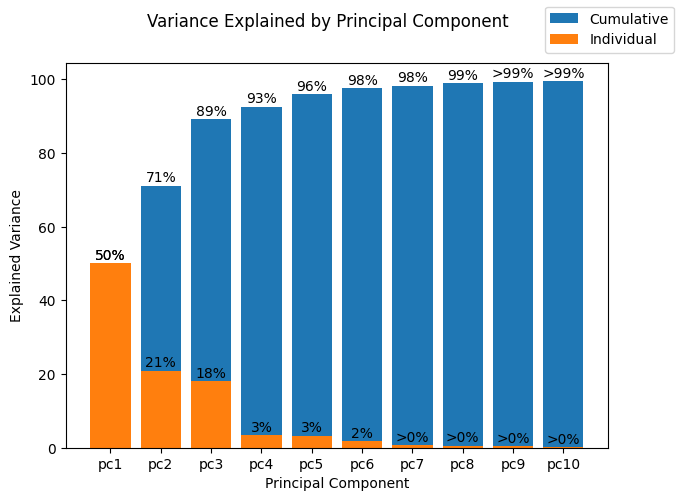

In [151]:
# Generate PCA dataset
n_components = 10
pca = PCA(n_components=n_components).fit(data_min_max.fillna(-30))

# Acquire explained variance ratios
var_ratios = 100 * pca.explained_variance_ratio_
var_ratios_cum = np.tri(n_components) @ var_ratios

# Fig settings
fig, ax = plt.subplots(figsize=(7,5))

# Define column labels and formatting options
labels = [f"pc{i}" for i in range(1, n_components+1)]
y_offset = 1


def label_col_chart(y_data, label_offset, **kwargs):
    for _col in range(len(y_data)):
        
        datum = y_data[_col]
        
        if datum > 99 and datum < 100:
            data_label = f">{np.floor(datum):.0f}%"
        elif datum > 0 and datum < 1:
            data_label = f">{np.floor(datum):.0f}%"
        else:
            data_label = f"{np.round(datum):.0f}%"
            
        plt.text(
            _col,
            y_data[_col] + label_offset,
            data_label,
            **kwargs
        )

# Plot cumulative
ax.bar(labels, var_ratios_cum, label='Cumulative')
label_col_chart(var_ratios_cum, y_offset, ha='center')

# Plot individual
ax.bar(labels, var_ratios, label='Individual')
label_col_chart(var_ratios, y_offset, ha='center')

# Figure formatting
fig.suptitle("Variance Explained by Principal Component")
ax.set_ylabel("Explained Variance")
ax.set_xlabel("Principal Component")
fig.legend();

### Normalize with `StandardScaler`

In [130]:
# move the song_id into the index to retain the information, without being affected by the transformations
data = pivoted_song_df.set_index('song_id')
scaler = StandardScaler().fit(data)
data_standard_scaler = scaler.transform(data)
data_standard_scaler = pd.DataFrame(data_standard_scaler)
data_standard_scaler.columns = data.columns
data_standard_scaler.index = data.index
data_standard_scaler

,bass_chord_ratio,bass_mel_rms_mean,bass_mel_rms_std,bass_notes_per_second_mean,bass_rms_energy_mean,bass_spectral_centroid_mean,bass_sustain_ratio,keys_chord_ratio,keys_mel_rms_mean,keys_mel_rms_std,keys_notes_per_second_mean,keys_rms_energy_mean,keys_spectral_centroid_mean,keys_sustain_ratio,lead_chord_ratio,lead_mel_rms_mean,lead_mel_rms_std,lead_notes_per_second_mean,lead_rms_energy_mean,lead_spectral_centroid_mean,lead_sustain_ratio,rhythm_chord_ratio,rhythm_mel_rms_mean,rhythm_mel_rms_std,rhythm_notes_per_second_mean,rhythm_rms_energy_mean,rhythm_spectral_centroid_mean,rhythm_sustain_ratio
song_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.573848,-0.242141,-0.055376,-0.112652,-0.242141,0.390684,-0.557514,-0.592616,-0.247684,-0.053328,-0.069586,-0.247684,0.380808,-0.560109
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.360295,0.013268,-0.089747,-0.305409,0.013268,0.483719,0.262808,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.569760,-0.056936,-0.029752,1.093918,-0.056936,-0.928630,-0.685809,-0.588530,-0.055497,-0.025426,1.175966,-0.055497,-0.928575,-0.686246
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.965610,0.164192,-0.050650,-0.936054,0.164192,-0.991277,0.317549,-0.984215,0.173968,-0.048182,-0.919590,0.173968,-0.990751,0.300227
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.141520,0.039202,-0.011657,-1.224037,0.039202,-0.930367,-0.041206,-1.160051,0.044265,-0.005722,-1.216876,0.044265,-0.930300,-0.052490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6942,-0.312438,-0.149371,-0.626103,0.804393,-0.149371,-1.149595,-0.332791,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.115746,-0.020368,-0.051069,-0.602075,-0.020368,-0.197906,0.128062,0.096692,-0.017550,-0.048638,-0.574821,-0.017550,-0.203351,0.113929
6944,1.655618,-1.187067,-0.820136,1.294095,-1.187067,1.473052,-0.506863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.331802,-0.204037,-0.048019,0.161774,-0.204037,0.769188,-0.018787,0.312658,-0.208143,-0.045317,0.213707,-0.208143,0.756464,-0.030449
6945,1.924185,-0.260693,-0.223229,-0.177911,-0.260693,-0.070696,-0.510957,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.118574,-0.145002,-0.067553,-0.260695,-0.145002,0.199684,-0.559322,-1.137115,-0.146883,-0.066588,-0.222412,-0.146883,0.191246,-0.561887


In [131]:
# Inspect minimum and maximum values
data_standard_scaler_value_ranges = pd.concat([data_standard_scaler.min(axis=0), data_standard_scaler.max(axis=0)], axis=1)
data_standard_scaler_value_ranges.columns = ['min_val', 'max_val']
data_standard_scaler_value_ranges

,min_val,max_val
bass_chord_ratio,-0.312438,6.477072
bass_mel_rms_mean,-1.421678,6.597375
bass_mel_rms_std,-0.942833,11.970013
bass_notes_per_second_mean,-2.286972,5.517093
bass_rms_energy_mean,-1.421678,6.597375
bass_spectral_centroid_mean,-2.288711,3.488352
bass_sustain_ratio,-0.824944,3.763764
keys_chord_ratio,-1.083113,2.410294
keys_mel_rms_mean,-0.084597,26.497286
keys_mel_rms_std,-0.057068,28.105200


#### Impute missing values

In [135]:
# Replace null values with an extreme value
data_standard_scaler = data_standard_scaler.fillna(-30)
data_standard_scaler

,bass_chord_ratio,bass_mel_rms_mean,bass_mel_rms_std,bass_notes_per_second_mean,bass_rms_energy_mean,bass_spectral_centroid_mean,bass_sustain_ratio,keys_chord_ratio,keys_mel_rms_mean,keys_mel_rms_std,keys_notes_per_second_mean,keys_rms_energy_mean,keys_spectral_centroid_mean,keys_sustain_ratio,lead_chord_ratio,lead_mel_rms_mean,lead_mel_rms_std,lead_notes_per_second_mean,lead_rms_energy_mean,lead_spectral_centroid_mean,lead_sustain_ratio,rhythm_chord_ratio,rhythm_mel_rms_mean,rhythm_mel_rms_std,rhythm_notes_per_second_mean,rhythm_rms_energy_mean,rhythm_spectral_centroid_mean,rhythm_sustain_ratio
song_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,-30.000000,-30.000000,-30.000000,-30.000000,-30.000000,-30.000000,-30.000000,-30.0,-30.0,-30.0,-30.0,-30.0,-30.0,-30.0,-0.573848,-0.242141,-0.055376,-0.112652,-0.242141,0.390684,-0.557514,-0.592616,-0.247684,-0.053328,-0.069586,-0.247684,0.380808,-0.560109
2,-30.000000,-30.000000,-30.000000,-30.000000,-30.000000,-30.000000,-30.000000,-30.0,-30.0,-30.0,-30.0,-30.0,-30.0,-30.0,0.360295,0.013268,-0.089747,-0.305409,0.013268,0.483719,0.262808,-30.000000,-30.000000,-30.000000,-30.000000,-30.000000,-30.000000,-30.000000
3,-30.000000,-30.000000,-30.000000,-30.000000,-30.000000,-30.000000,-30.000000,-30.0,-30.0,-30.0,-30.0,-30.0,-30.0,-30.0,-0.569760,-0.056936,-0.029752,1.093918,-0.056936,-0.928630,-0.685809,-0.588530,-0.055497,-0.025426,1.175966,-0.055497,-0.928575,-0.686246
5,-30.000000,-30.000000,-30.000000,-30.000000,-30.000000,-30.000000,-30.000000,-30.0,-30.0,-30.0,-30.0,-30.0,-30.0,-30.0,-0.965610,0.164192,-0.050650,-0.936054,0.164192,-0.991277,0.317549,-0.984215,0.173968,-0.048182,-0.919590,0.173968,-0.990751,0.300227
6,-30.000000,-30.000000,-30.000000,-30.000000,-30.000000,-30.000000,-30.000000,-30.0,-30.0,-30.0,-30.0,-30.0,-30.0,-30.0,-1.141520,0.039202,-0.011657,-1.224037,0.039202,-0.930367,-0.041206,-1.160051,0.044265,-0.005722,-1.216876,0.044265,-0.930300,-0.052490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6942,-0.312438,-0.149371,-0.626103,0.804393,-0.149371,-1.149595,-0.332791,-30.0,-30.0,-30.0,-30.0,-30.0,-30.0,-30.0,0.115746,-0.020368,-0.051069,-0.602075,-0.020368,-0.197906,0.128062,0.096692,-0.017550,-0.048638,-0.574821,-0.017550,-0.203351,0.113929
6944,1.655618,-1.187067,-0.820136,1.294095,-1.187067,1.473052,-0.506863,-30.0,-30.0,-30.0,-30.0,-30.0,-30.0,-30.0,0.331802,-0.204037,-0.048019,0.161774,-0.204037,0.769188,-0.018787,0.312658,-0.208143,-0.045317,0.213707,-0.208143,0.756464,-0.030449
6945,1.924185,-0.260693,-0.223229,-0.177911,-0.260693,-0.070696,-0.510957,-30.0,-30.0,-30.0,-30.0,-30.0,-30.0,-30.0,-1.118574,-0.145002,-0.067553,-0.260695,-0.145002,0.199684,-0.559322,-1.137115,-0.146883,-0.066588,-0.222412,-0.146883,0.191246,-0.561887


#### PCA with `StandardScaler`

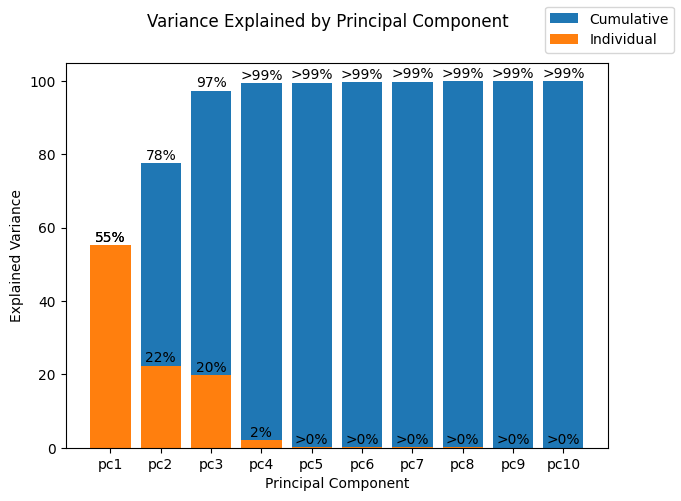

In [153]:
# Generate PCA dataset
n_components = 10
pca = PCA(n_components=n_components).fit(data_standard_scaler)

# Acquire explained variance ratios
var_ratios = 100 * pca.explained_variance_ratio_
var_ratios_cum = np.tri(n_components) @ var_ratios

# Fig settings
fig, ax = plt.subplots(figsize=(7,5))

# Define column labels and formatting options
labels = [f"pc{i}" for i in range(1, n_components+1)]
y_offset = 1

def label_col_chart(y_data, label_offset, **kwargs):
    for _col in range(len(y_data)):
        
        datum = y_data[_col]
        
        if datum > 99 and datum < 100:
            data_label = f">{np.floor(datum):.0f}%"
        elif datum > 0 and datum < 1:
            data_label = f">{np.floor(datum):.0f}%"
        else:
            data_label = f"{np.round(datum):.0f}%"
            
        plt.text(
            _col,
            y_data[_col] + label_offset,
            data_label,
            **kwargs
        )

# Plot cumulative
ax.bar(labels, var_ratios_cum, label='Cumulative')
label_col_chart(var_ratios_cum, y_offset, ha='center')

# Plot individual
ax.bar(labels, var_ratios, label='Individual')
label_col_chart(var_ratios, y_offset, ha='center')

# Figure formatting
fig.suptitle("Variance Explained by Principal Component")
ax.set_ylabel("Explained Variance")
ax.set_xlabel("Principal Component")
fig.legend();

5 principal components capture 93% of the variance, while adding any additional components captures at most ~1%. **Nevertheless, we will evaluate each clustering model with different number of principal components**

## Clustering

For clustering, we will evaluate three separate models:

1. `KMeans`
2. `DBSCAN`
3. `GaussianMixture` (Gaussian Mixture Models, or GMMs)

For each model, a variety of different PCA datasets and hyperparameters will be tried, and the resulting clusters and cluster labels will be tested against our validation set and each other.

Prepare the collection of the evaluation data

In [ ]:
# Ensure that the validation genre labels map correctly
song_genre = validation_df.loc[:, ['song_id', 'genre_id']].drop_duplicates()
song_genre = pd.merge(pd.DataFrame(data_scaled.index), song_genre, on='song_id')

poss_principal_components = range(3, 6)

Generate each pca datasets

In [26]:
pca_datasets = []
for n_components in poss_principal_components:
    pca_dataset = PCA(
            n_components=n_components
        ).fit_transform(data_scaled)
    pca_datasets.append(pca_dataset)

### Clustering with `KMeans`

In [27]:
max_clusters = validation_df.genre_id.max() + 1
# From .5 - 1.5 times the number of genres: super-genres and sub-genres
poss_clusters = range(8, max_clusters+9)

n_hyperparameters = len(pca_datasets) * len(poss_clusters)

model_metrics = [[]] * n_hyperparameters
model_ids = [''] * n_hyperparameters
model_labels = [[]] * n_hyperparameters
row_index = 0


for n_components, pca_dataset in zip(poss_principal_components, pca_datasets):    
    for n_clusters in poss_clusters:
        kmeans = KMeans(
            n_clusters=n_clusters,
            random_state=RANDOM_STATE
        ).fit(pca_dataset)   
            
        # Store the cluster labeling by each model
        model_name = "kmeans"
        model_ids[row_index] = f"{model_name}_nclusters={n_clusters}_ncomponents={n_components}"
        model_labels[row_index] = kmeans.labels_
        
        # Evaluation
        model_metrics[row_index] = [
            model_name,
            n_clusters, # hyperparameter
            n_components,
            silhouette_score(pca_dataset, kmeans.labels_),
            homogeneity_score(song_genre.genre_id, kmeans.labels_),
            completeness_score(song_genre.genre_id, kmeans.labels_)
        ]
        row_index += 1

Add `model_id` and `model_labels` to the `song_genre` dataframe

In [28]:
song_genre = pd.concat(
    [song_genre, pd.DataFrame({_id: _labels for _id, _labels in zip(model_ids, model_labels)})],
    axis=1
)

Store evaluation metrics

In [29]:
columns = [ 
    "model",
    "clusters",
    "n_components",
    "silhouette_score",
    "homogeneity_score",
    "completeness_score",    
]
kmeans_eval_df = pd.DataFrame(model_metrics, columns=columns)
kmeans_eval_df.head()

,model,clusters,n_components,silhouette_score,homogeneity_score,completeness_score
0,kmeans,8,3,0.583641,0.048925,0.055550
1,kmeans,9,3,0.556614,0.049799,0.048387
2,kmeans,10,3,0.555145,0.050670,0.047569
3,kmeans,11,3,0.548684,0.052570,0.044738
4,kmeans,12,3,0.549275,0.052871,0.044943


#### Evaluations

##### Evaluate how the number of principal components affects the performance of the `KMeans` algorithm

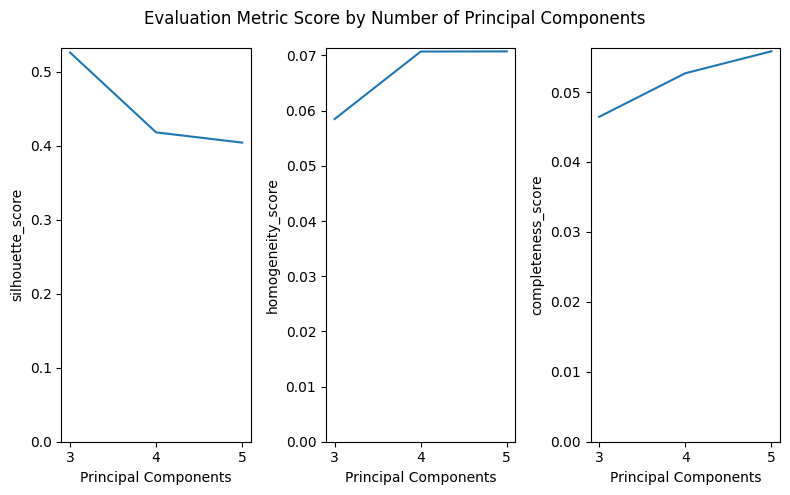

In [31]:
# Average performance by principal components
perf_by_components = kmeans_eval_df.loc[:, ['n_components'] + METRICS].groupby('n_components').mean()

plot_metrics_by_1param(
    perf_by_components,
    fig_title="Evaluation Metric Score by Number of Principal Components",
    x_label="Principal Components",
    figsize=(8,5)
)

##### Evaluate the effect of the number of clusters on performance

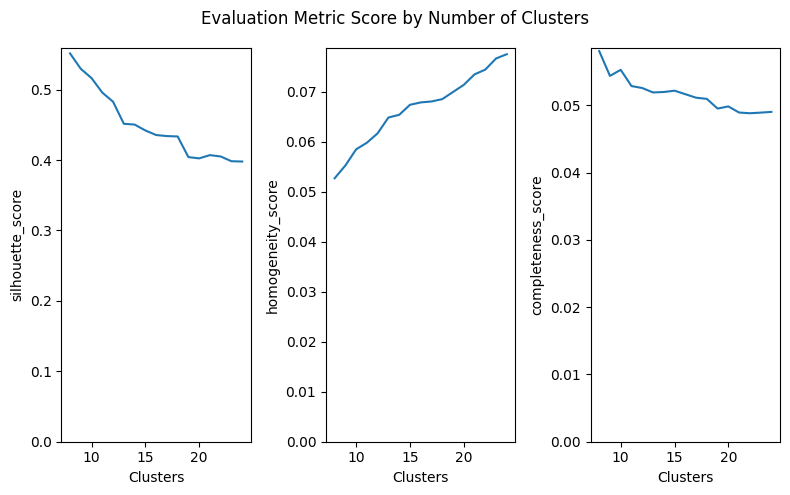

In [32]:
# Average performance by principal components
perf_by_cluster = kmeans_eval_df.loc[:, ['clusters'] + METRICS].groupby('clusters').mean()

plot_metrics_by_1param(
    perf_by_cluster,
    fig_title="Evaluation Metric Score by Number of Clusters",
    x_label="Clusters",
    figsize=(8,5)
)

##### Evaluate how the number of clusters and number of components affect performance

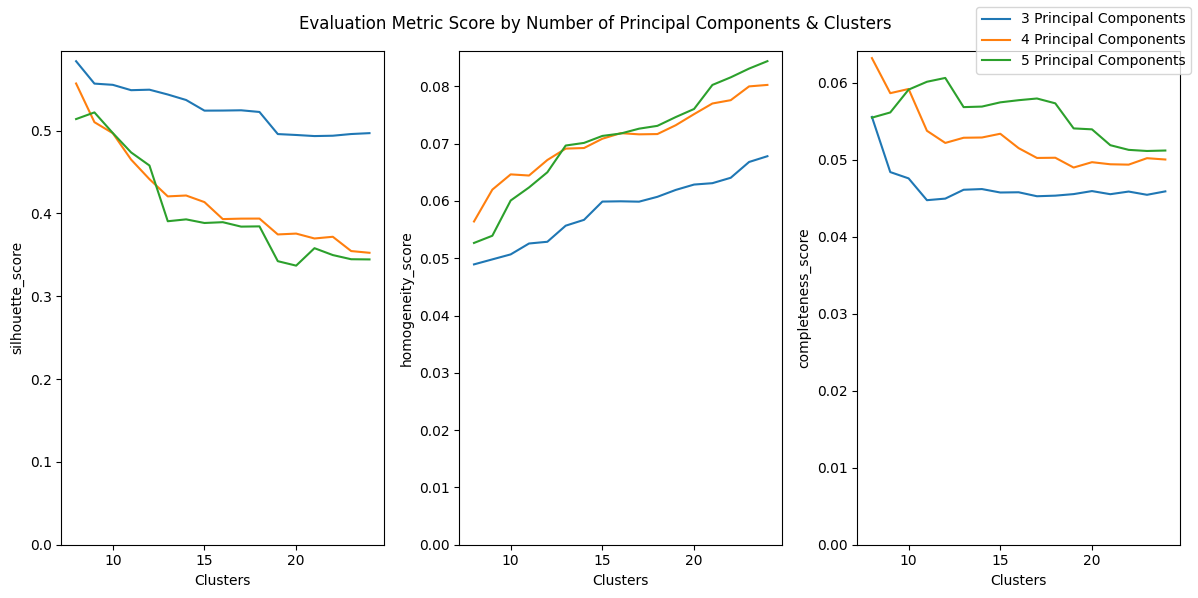

In [33]:
plot_metrics_by_2params(
    kmeans_eval_df,
    param1='clusters',
    param2='n_components',
    param2_lab='Principal Components',
    fig_title="Evaluation Metric Score by Number of Principal Components & Clusters",
    x_label="Clusters",
    figsize=(12,6)
)

### Clustering with `DBSCAN`

In [34]:
eps_list = [np.round(eps, 2) for eps in np.arange(.25, .876, .05)] # Handling floating point error 
min_samples_list = range(1, 10, 1)

n_hyperparameters = len(poss_principal_components) * len(eps_list) * len(min_samples_list)

model_metrics = [[]] * n_hyperparameters
model_ids = [''] * n_hyperparameters
model_labels = [[]] * n_hyperparameters
# print(len(model_metrics))
row_index = 0

for n_components, pca_dataset in zip(poss_principal_components, pca_datasets):
    for eps in eps_list:
        for min_samples in min_samples_list:
            dbscan = DBSCAN(
                eps=eps,
                min_samples=min_samples,
                n_jobs=-1
            ).fit(pca_dataset)            
            
            # Store the cluster labeling by each model
            model_name = "dbscan"
            model_ids[row_index] = f"{model_name}_eps={eps}_minsamples={min_samples}_ncomponents={n_components}"
            model_labels[row_index] = dbscan.labels_
            
            # Generate 1 metrics row per model
            model_metrics[row_index] = [
                model_name,
                eps, # hyperparameters
                min_samples, # hyperparameters
                n_components,
                silhouette_score(pca_dataset, dbscan.labels_),
                homogeneity_score(song_genre.genre_id, dbscan.labels_),
                completeness_score(song_genre.genre_id, dbscan.labels_)
            ]
            
            row_index += 1


Add `model_id` and `model_labels` to the `song_genre` dataframe

In [35]:
song_genre = pd.concat(
    [song_genre, pd.DataFrame({_id: _labels for _id, _labels in zip(model_ids, model_labels)})],
    axis=1
)

Store evaluation metrics

In [36]:
columns = [ 
    "model",
    "eps",
    "min_samples",
    "n_components",
    "silhouette_score",
    "homogeneity_score",
    "completeness_score",    
]
dbscan_eval_df = pd.DataFrame(model_metrics, columns=columns)
dbscan_eval_df.head()

,model,eps,min_samples,n_components,silhouette_score,homogeneity_score,completeness_score
0,dbscan,0.25,1,3,0.923357,0.032279,0.059747
1,dbscan,0.25,2,3,0.931370,0.031460,0.058367
2,dbscan,0.25,3,3,0.931370,0.031460,0.058367
3,dbscan,0.25,4,3,0.931370,0.031460,0.058367
4,dbscan,0.25,5,3,0.931370,0.031460,0.058367


#### Evaluations

##### Evaluating one hyperparameter at a time

##### Evaluate effect of the number of principal components on the model

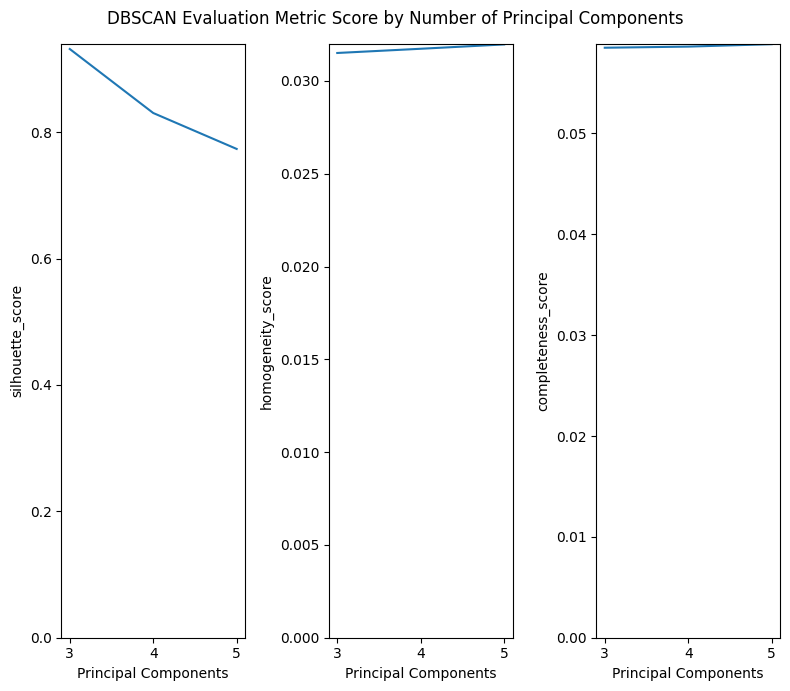

In [37]:
# Average performance by principal components
perf_by_components = dbscan_eval_df.loc[:, ['n_components'] + METRICS].groupby('n_components').mean()

plot_metrics_by_1param(
    perf_by_components,
    fig_title=f"{model_name.upper()} Evaluation Metric Score by Number of Principal Components",
    x_label="Principal Components",
    figsize=(8,7)
)

##### Evaluate the effect of eps on model performance

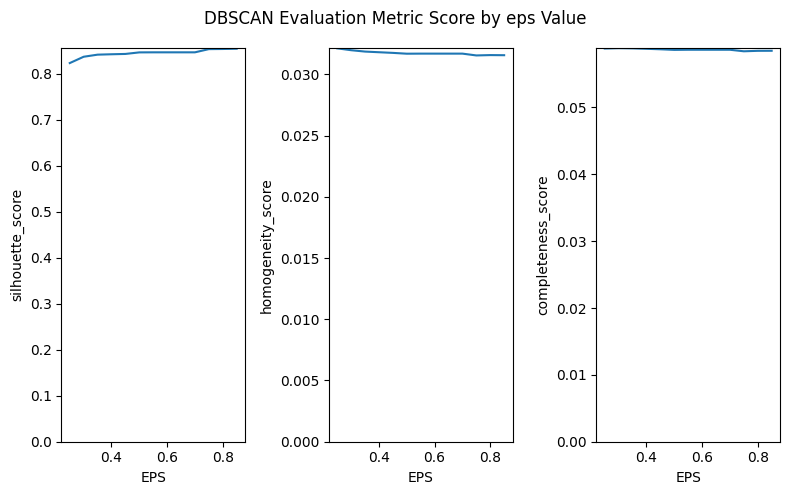

In [38]:
# Average performance by principal components
perf_by_components = dbscan_eval_df.loc[:, ['eps'] + METRICS].groupby('eps').mean()

plot_metrics_by_1param(
    perf_by_components,
    fig_title=f"{model_name.upper()} Evaluation Metric Score by eps Value",
    x_label="EPS",
    figsize=(8,5)
)

##### Evaluate the effect of `min_samples` on model performance

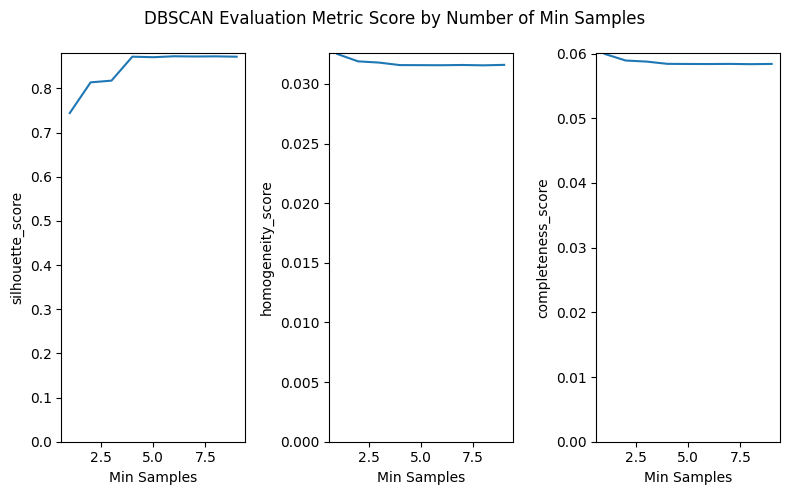

In [39]:
# Average performance by principal components
perf_by_components = dbscan_eval_df.loc[:, ['min_samples'] + METRICS].groupby('min_samples').mean()

plot_metrics_by_1param(
    perf_by_components,
    fig_title=f"{model_name.upper()} Evaluation Metric Score by Number of Min Samples",
    x_label="Min Samples",
    figsize=(8,5)
)

##### Evaluating two hyperparameters at a time

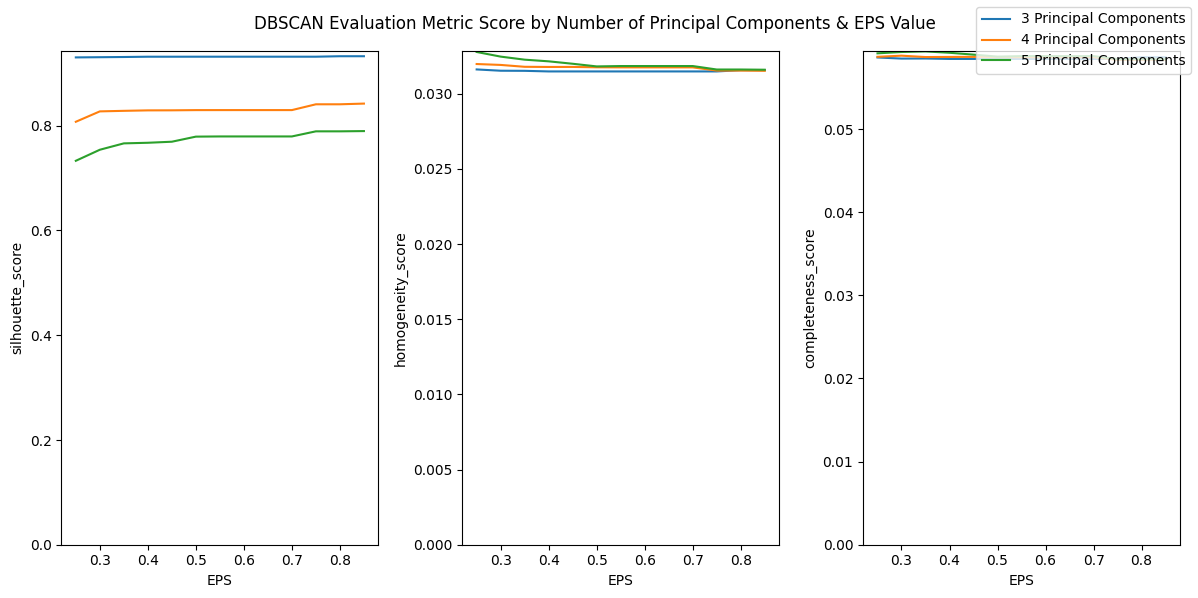

In [40]:
plot_metrics_by_2params(
    dbscan_eval_df,
    param1='eps',
    param2='n_components',
    param2_lab='Principal Components',
    fig_title=f"{model_name.upper()} Evaluation Metric Score by Number of Principal Components & EPS Value",
    x_label="EPS",
    figsize=(12,6)
)

##### Evaluate the effect of `min_samples` and the number of principal components on model performance

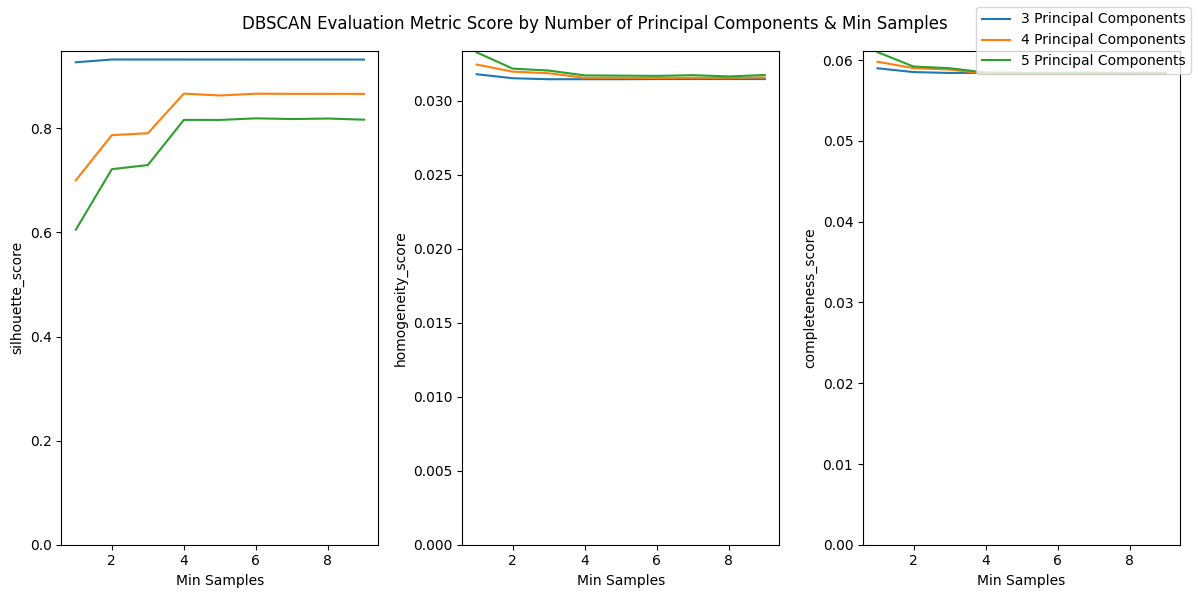

In [41]:
plot_metrics_by_2params(
    dbscan_eval_df,
    param1='min_samples',
    param2='n_components',
    param2_lab='Principal Components',
    fig_title=f"{model_name.upper()} Evaluation Metric Score by Number of Principal Components & Min Samples",
    x_label="Min Samples",
    figsize=(12,6)
)

##### Evaluate the effect of `min_samples` and `eps` on model performance

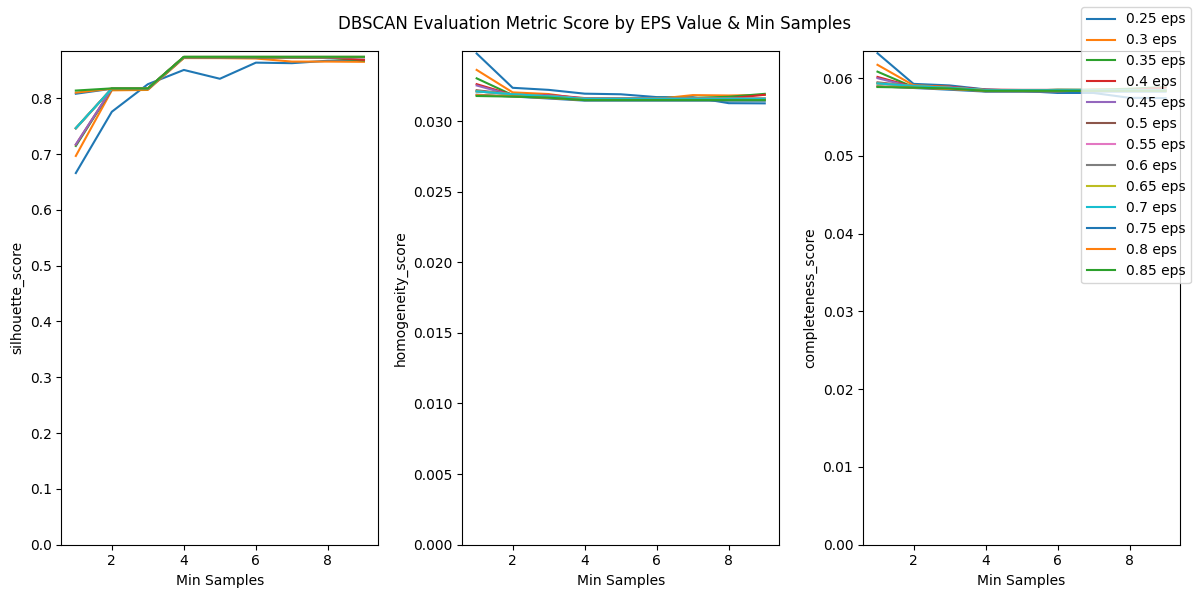

In [42]:
plot_metrics_by_2params(
    dbscan_eval_df,
    param1='min_samples',
    param2='eps',
    param2_lab='eps',
    fig_title=f"{model_name.upper()} Evaluation Metric Score by EPS Value & Min Samples",
    x_label="Min Samples",
    figsize=(12,6)
)

### Clustering with `GaussianMixture`

In [43]:
n_mixture_components = range(2, 25)
covariance_types = ['full', 'tied', 'diag', 'spherical']

# Because some models might produce 1 label, leading to errors, metrics data will simply be appende
model_metrics = []
model_ids = []
model_labels = []
row_index = 0

gmm_models_skipped = []

for n_components, pca_dataset in zip(poss_principal_components, pca_datasets):
    for covariance_type in covariance_types:
        for mixture_components in n_mixture_components:
            gmm = GaussianMixture(
                n_components=mixture_components,
                covariance_type=covariance_type,
                random_state=RANDOM_STATE
            ).fit(pca_dataset)   
                
            # Store the cluster labeling by each model
            model_name = "gmm"
            model_ids.append(f"{model_name}_covariancetype={covariance_type}_mixturecomponents={mixture_components}_ncomponents={n_components}")
            labels = gmm.predict(pca_dataset)
            
            # Some models only assign data to 1 cluster, which throws an error for the silhouette_score
            if len(set(labels)) == 1:
                gmm_models_skipped.append(model_id)
                continue
            
            model_labels.append(labels)
            
            # Evaluation
            model_metrics.append([
                model_name,
                covariance_type, # hyperparameter
                mixture_components, # hyperparameter
                n_components,
                silhouette_score(pca_dataset, labels),
                homogeneity_score(song_genre.genre_id, labels),
                completeness_score(song_genre.genre_id, labels)
            ])
            row_index += 1

print(f"{len(gmm_models_skipped)} out of {len(model_metrics)} models were skipped:")
print(gmm_models_skipped)


0 out of 276 models were skipped:
[]


Add `model_id` and `model_labels` to the `song_genre` dataframe

In [44]:
song_genre = pd.concat(
    [song_genre, pd.DataFrame({_id: _labels for _id, _labels in zip(model_ids, model_labels)})],
    axis=1
)

Store evaluation metrics

In [45]:
columns = [ 
    "model",
    "covariance_type",
    "mixture_components",
    "n_components",
    "silhouette_score",
    "homogeneity_score",
    "completeness_score",    
]
gmm_eval_df = pd.DataFrame(model_metrics, columns=columns)
gmm_eval_df.head()

,model,covariance_type,mixture_components,n_components,silhouette_score,homogeneity_score,completeness_score
0,gmm,full,2,3,0.766411,0.011998,0.043434
1,gmm,full,3,3,0.841630,0.020943,0.052463
2,gmm,full,4,3,0.916438,0.025452,0.049350
3,gmm,full,5,3,0.924957,0.026749,0.050773
4,gmm,full,6,3,0.932012,0.031237,0.058199


#### Evaluations

##### Evaluating one hyperparameter at a time

##### Model performance by number of principal components

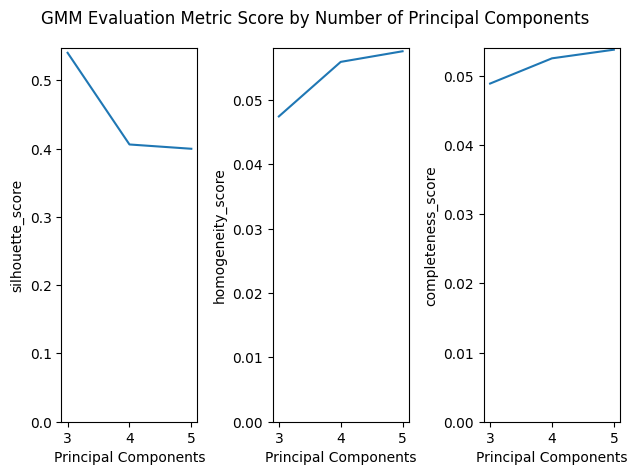

In [62]:
hyperparameter = ['n_components']

# Average performance by principal components
perf_by_hyperparameter = gmm_eval_df.loc[:, hyperparameter + METRICS].groupby(hyperparameter).mean()

plot_metrics_by_1param(
    perf_by_hyperparameter,
    fig_title=f"{model_name.upper()} Evaluation Metric Score by Number of Principal Components",
    x_label="Principal Components",
)

##### Performance by number of mixture components

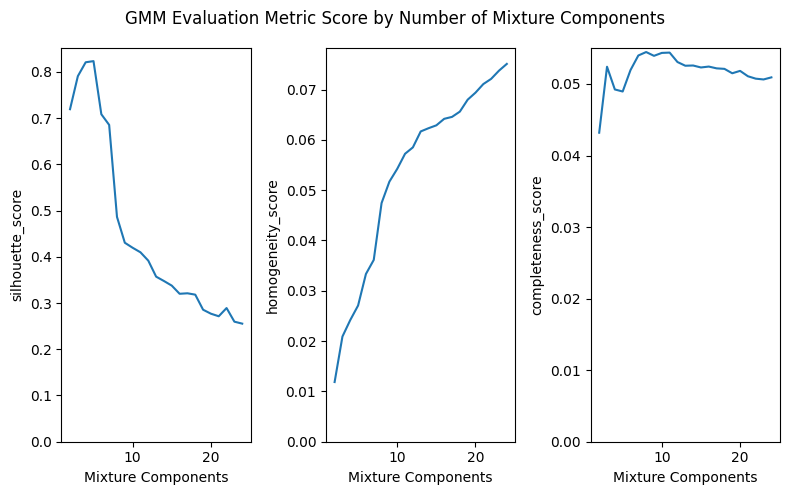

In [63]:
hyperparameter = ['mixture_components']

# Average performance by principal components
perf_by_hyperparameter = gmm_eval_df.loc[:, hyperparameter + METRICS].groupby(hyperparameter).mean()

plot_metrics_by_1param(
    perf_by_hyperparameter,
    fig_title=f"{model_name.upper()} Evaluation Metric Score by Number of Mixture Components",
    x_label="Mixture Components",
    figsize=(8,5)
)

##### Performance by covariance type

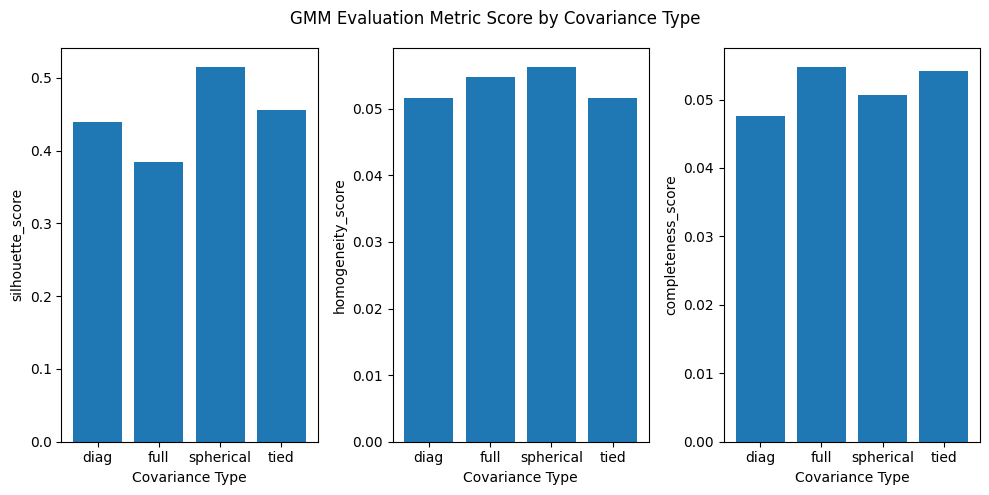

In [ ]:
hyperparameter = ['covariance_type']

# Average performance by principal components
perf_by_hyperparameter = gmm_eval_df.loc[:, hyperparameter + METRICS].groupby(hyperparameter).mean()

plot_metrics_by_1param(
    perf_by_hyperparameter,
    bar=True,
    fig_title=f"{model_name.upper()} Evaluation Metric Score by Covariance Type",
    x_label="Covariance Type",
    figsize=(10,5),
    tight_layout=True
)

##### Evaluating two hyperparameters at a time

by number of principal components and mixture components

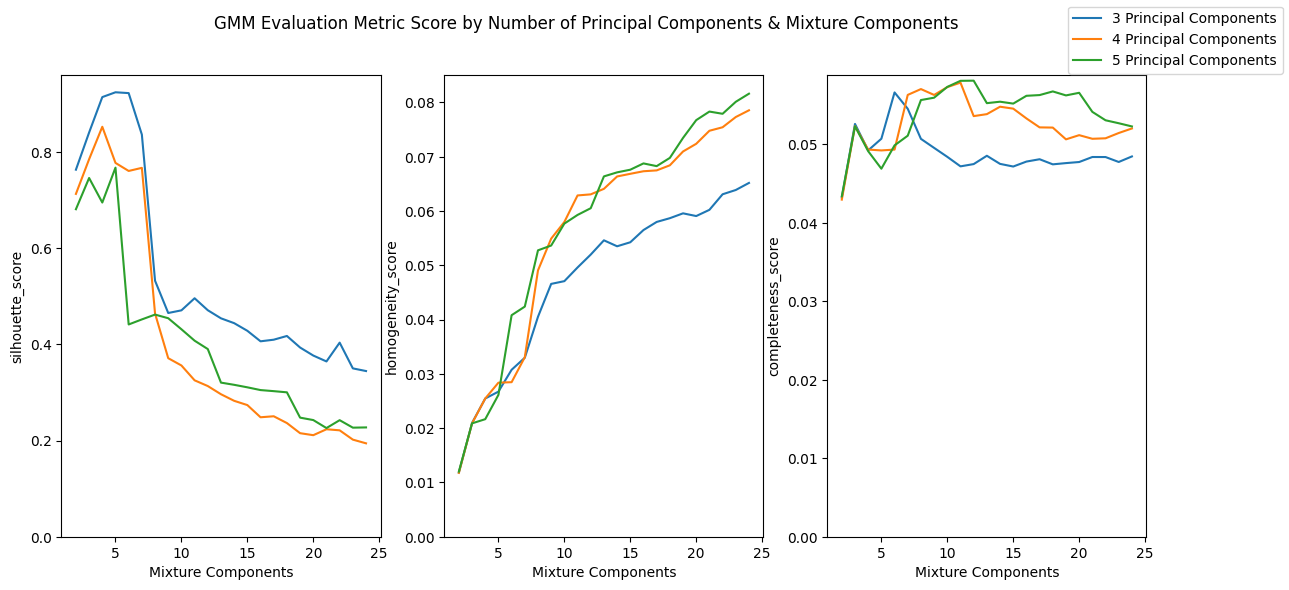

In [72]:
plot_metrics_by_2params(
    gmm_eval_df,
    param1='mixture_components',
    param2='n_components',
    param2_lab='Principal Components',
    fig_title=f"{model_name.upper()} Evaluation Metric Score by Number of Principal Components & Mixture Components",
    x_label="Mixture Components",
    figsize=(14,6),
    tight_layout=False
)

##### by `covariance_type` and number of mixture components

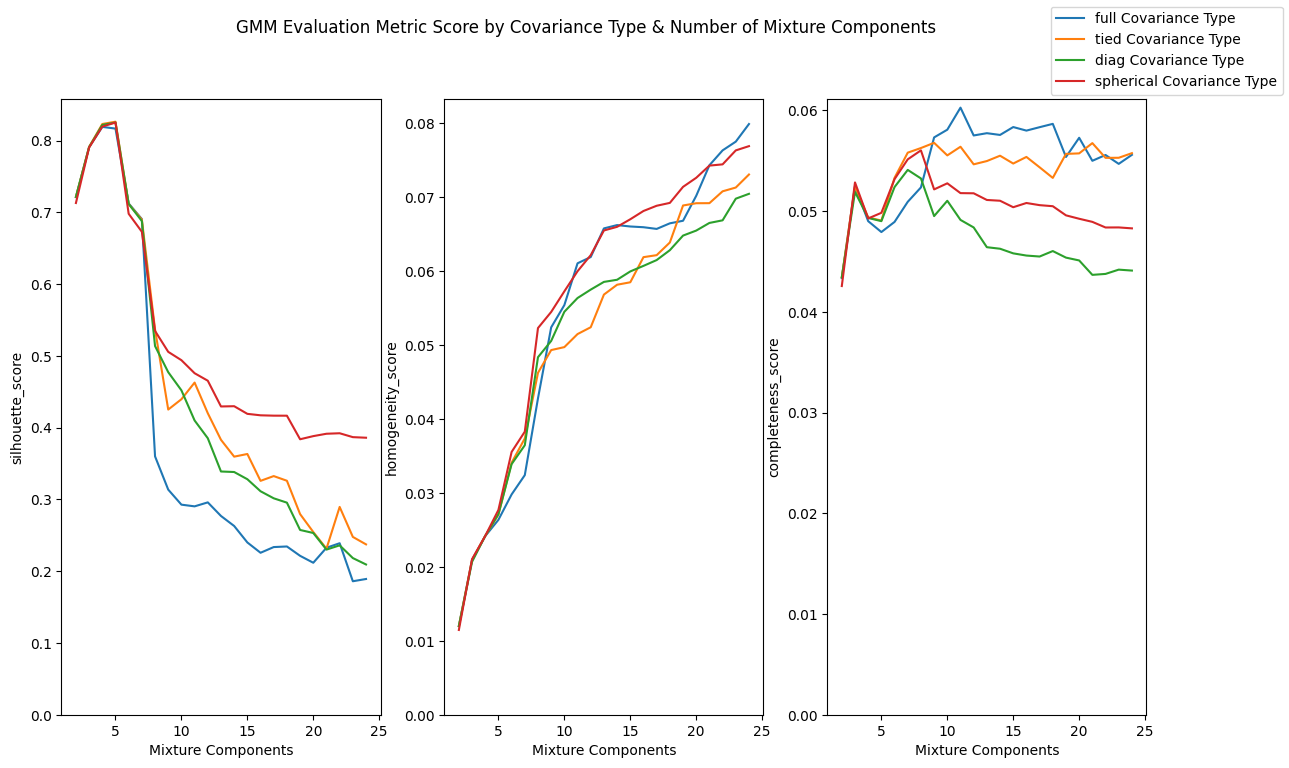

In [ ]:
plot_metrics_by_2params(
    gmm_eval_df,
    param1='mixture_components',
    param2='covariance_type',
    param2_lab='Covariance Type',
    fig_title=f"{model_name.upper()} Evaluation Metric Score by Covariance Type & Number of Mixture Components",
    x_label="Mixture Components",
    figsize=(14,8),
    tight_layout=False
)

##### by `covariance_type` and number of principal components

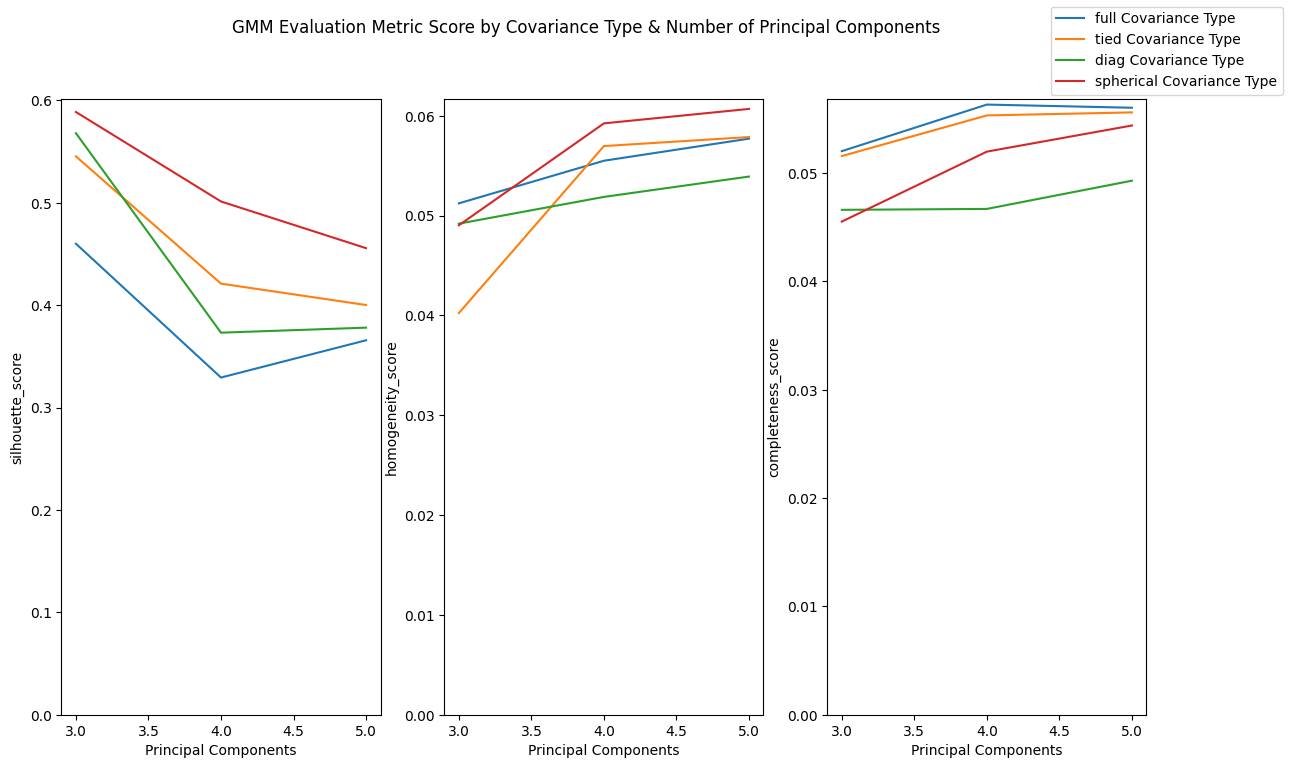

In [ ]:
plot_metrics_by_2params(
    gmm_eval_df,
    param1='n_components',
    param2='covariance_type',
    param2_lab='Covariance Type',
    fig_title=f"{model_name.upper()} Evaluation Metric Score by Covariance Type & Number of Principal Components",
    x_label="Principal Components",
    figsize=(14,8),
    tight_layout=False
)

### Cross model comparisons

When considering the number of principal components effect on model performance we found the following:

- `KMeans`: Performed better across all metrics as the number of principal components used in the training dataset increased from 3-5
- `DBSCAN`: Increasing the number of principal components slightly decreased the `silhouette_score` and had almost no effect on `homogeneity` or `completeness`
- `GaussianMixture`: Similar to `DBSCAN`, increasing the number of principal components lead to a downward trend in the `silhouette_score`, and had almost no effect on `homogeneity`. Increasing the number of components slightly improved the `completeness_score`.

Below we can visualize this more concisely.

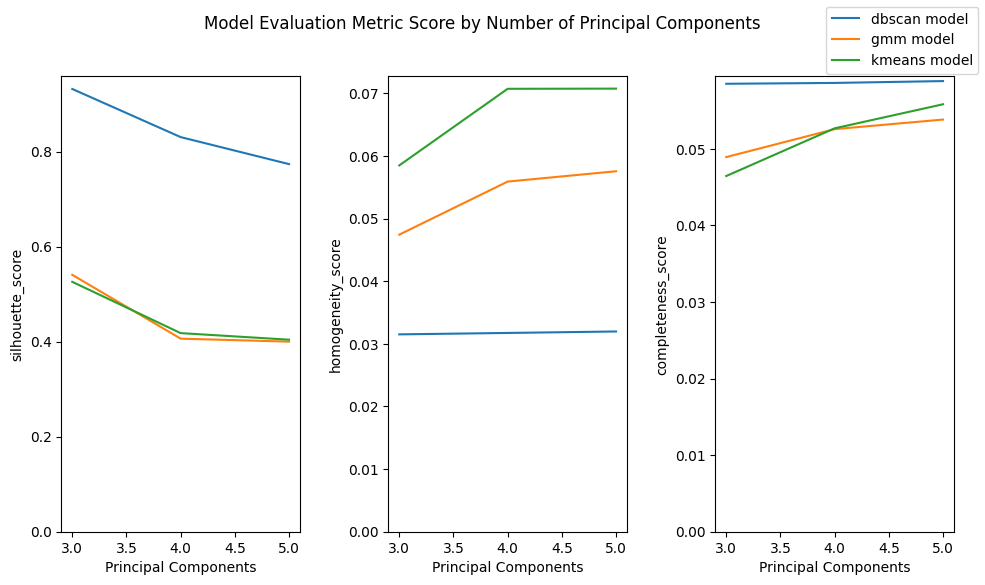

In [ ]:
cols_to_keep = [
    'model',
    'n_components',
    'silhouette_score',
    'homogeneity_score',
    'completeness_score'
]

model_evaluation_dfs = [
    kmeans_eval_df.loc[:, cols_to_keep],
    dbscan_eval_df.loc[:, cols_to_keep],
    gmm_eval_df.loc[:, cols_to_keep]
]

perf_by_model_and_components_df = pd.concat(model_evaluation_dfs).groupby(['model', 'n_components']).mean().reset_index()

plot_metrics_by_2params(
    perf_by_model_and_components_df,
    param1='n_components',
    param2='model',
    param2_lab='model',
    fig_title="Model Evaluation Metric Score by Number of Principal Components",
    x_label="Principal Components",
    figsize=(10,6),
)

This view into the models' performances does not provide a clear "better" model in the aggregate - however, the `GaussianMixture` model never achieves the highest score across any metric. Although more views of the performances should be considered, it's worth noting that we might need to choose based on non-performance based criteria.

For instance, although having the actual genre labels would suggest that the `homogeneity` and `completeness` scores should be considered the most informative, it's clear that all models perform quite abysmally. This isn't too surprising as the `homogeneity` score should not be high if the maximum number of predicted clusters is less than the actual number of genres, because there *should* expect that several (if not all) predicted clusters would be comprised of multiple genres. `completeness` scores on the other hand should be low when the model produces a higher number of predictor clusters than there are distinct genres, because none of the clusters could be considered complete.

With that in mind, it would be meaningful to look at the distribution of predicted clusters for each model - note that this won't reveal any new information for `KMeans` as the number of clusters is a hyperparameter.

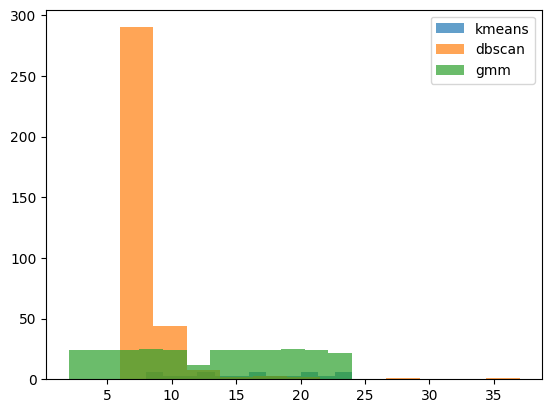

In [95]:
models = [
    'kmeans',
    'dbscan',
    'gmm'
]

cluster_counts = {
    'kmeans': [],
    'dbscan': [],
    'gmm': []
}

n_clusters_per_model = song_genre.nunique()

for model in models:
    model_cols = [col for col in song_genre.columns if model in col]
    cluster_counts[model] = n_clusters_per_model[model_cols].values.tolist()
    plt.hist(cluster_counts[model], bins=12, label=model, alpha=.7)
plt.legend();

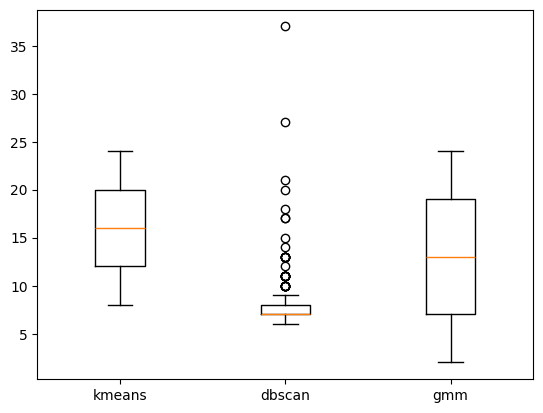

In [96]:
cluster_counts_list = [val for key, val in cluster_counts.items()]
plt.boxplot(
    cluster_counts_list,
    tick_labels=models
);

When considering `DBSCAN` and `GaussianMixture` cluster distribution, it makes more sense why `GaussianMixture` performed so poorly on the `completeness` and `homogeneity` scores. It could be worthwhile to visualize how the number of clusters affected performance to see if that could help rule out any specific models.

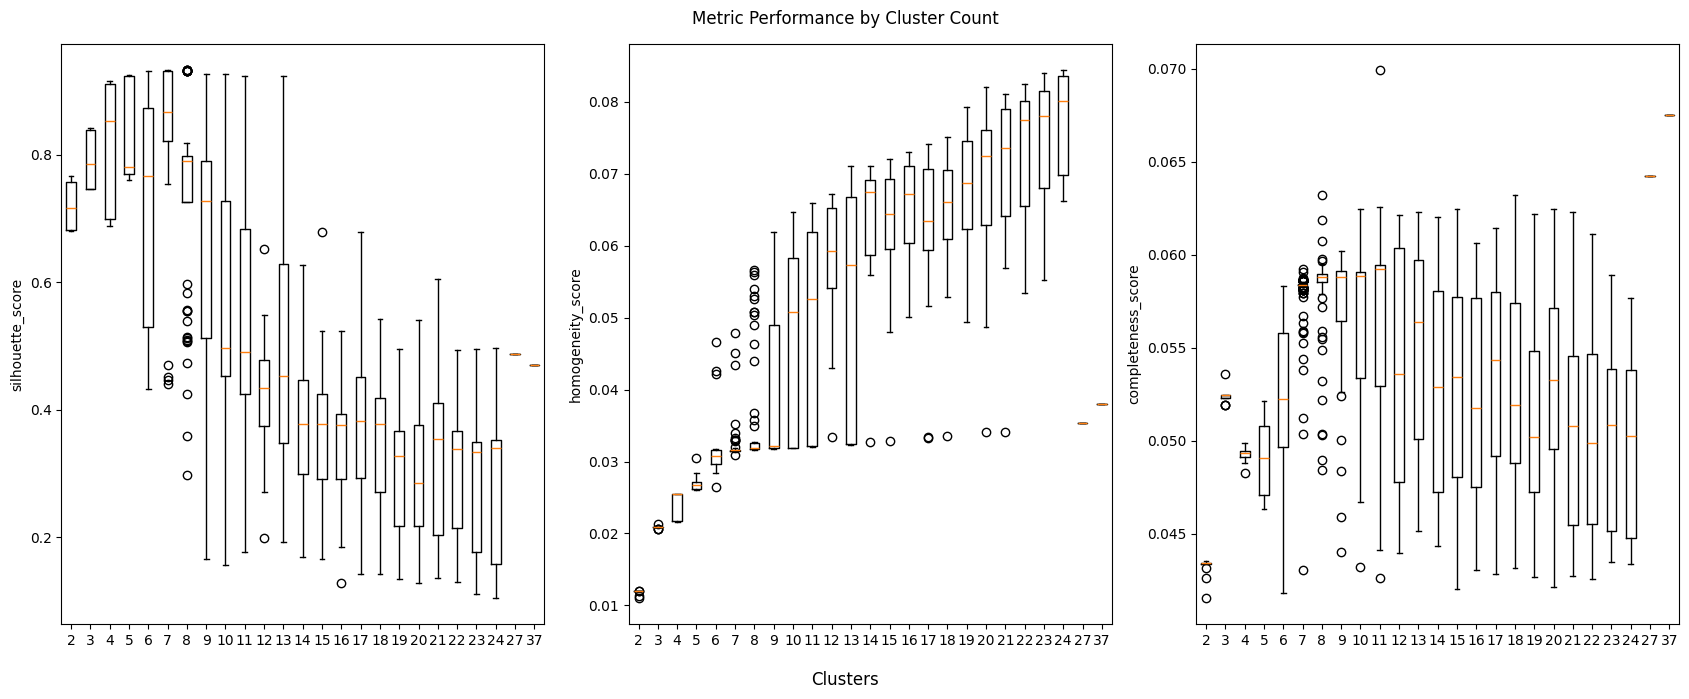

In [99]:
# Because the concatenation is occuring in the same order that the models were generated, we don't need to worry about special mapping methods
model_evaluation_df = pd.concat(model_evaluation_dfs)
model_evaluation_df.loc[:, 'n_clusters'] = n_clusters_per_model.iloc[2:].values # ignoring the song_id and genre_id columns

clusters = sorted(model_evaluation_df.n_clusters.unique())

silhouette_by_cluster = []
homogeneity_by_cluster = []
completeness_by_cluster = []

for cluster in clusters:
    silhouette_scores = model_evaluation_df.loc[model_evaluation_df.n_clusters == cluster, 'silhouette_score'].tolist()
    silhouette_by_cluster.append(silhouette_scores)
                                 
    homogeneity_scores = model_evaluation_df.loc[model_evaluation_df.n_clusters == cluster, 'homogeneity_score'].tolist()
    homogeneity_by_cluster.append(homogeneity_scores)
                                 
    completeness_scores = model_evaluation_df.loc[model_evaluation_df.n_clusters == cluster, 'completeness_score'].tolist()
    completeness_by_cluster.append(completeness_scores)
    
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(17,7))

by_cluster_scores = [
    silhouette_by_cluster,
    homogeneity_by_cluster,
    completeness_by_cluster
]

for i in range(3):
    ax[i].boxplot(
        by_cluster_scores[i],
        tick_labels=clusters
    )
    
    ax[i].set_ylabel(METRICS[i])

fig.supxlabel("Clusters")
fig.suptitle("Metric Performance by Cluster Count")
fig.tight_layout();

This visual also shows that there isn't a clear directionality based on a single feature (i.e., number of clusters). Therefore it would be worthwhile to compare individual model performance within each metric, and across each metric.

We will start by considering a single metric at a time:

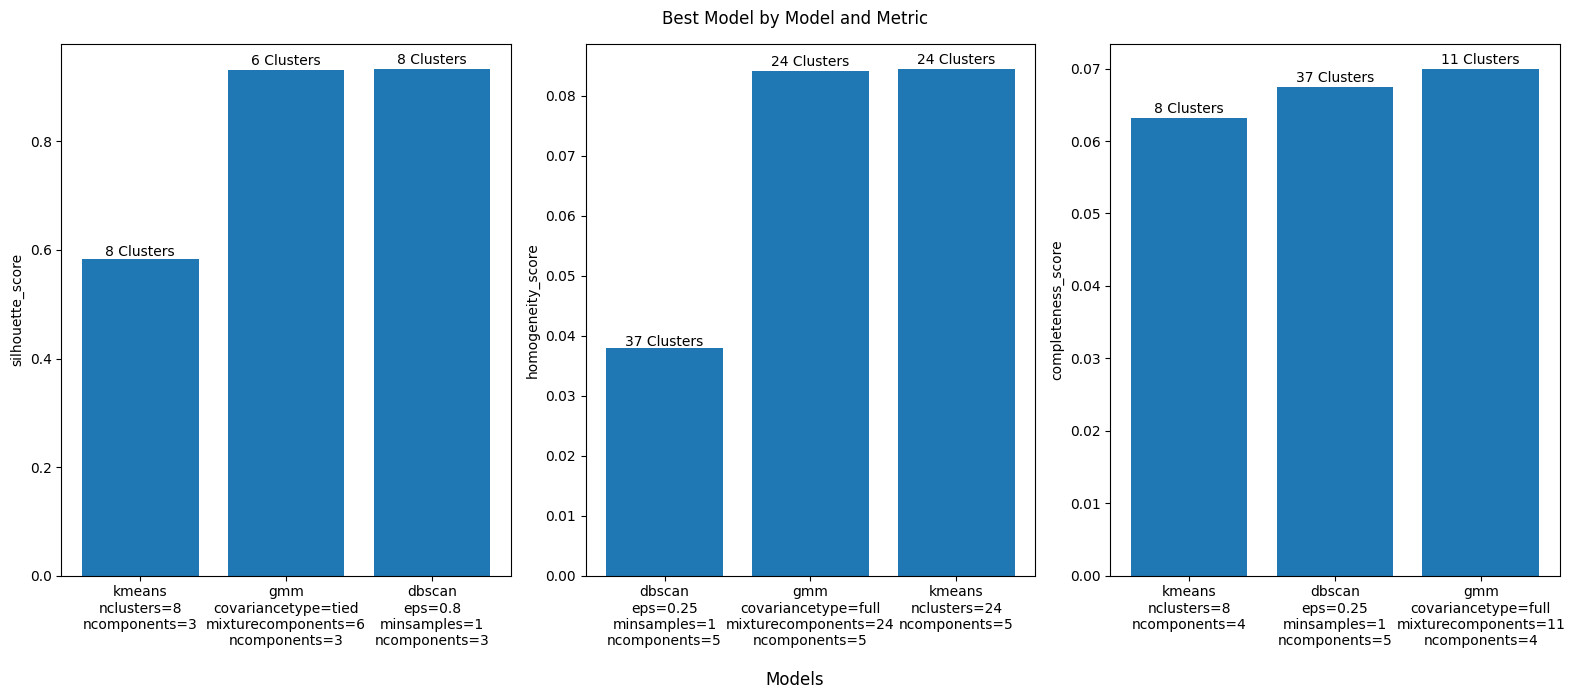

In [100]:
# best_model_by_silhouette = model_evaluation_df
# best_model_by_silhouette

model_evaluation_df.index = n_clusters_per_model.iloc[2:].index # ignoring the song_id and genre_id columns

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,7))


for i in range(3):    
    best_models = model_evaluation_df.loc[:, ['model', METRICS[i], 'n_clusters']].sort_values(by=['model', METRICS[i]], ascending=[True, False]).drop_duplicates(subset='model')
    best_models.reset_index(inplace=True, names='model_id')
    best_models.sort_values(by=METRICS[i], inplace=True) # Ensure chart is ordered from greatest to least
    
    ax[i].bar(
        best_models.loc[:, 'model_id'].str.replace('_', '\n'),
        best_models.loc[:, METRICS[i]],
        label=best_models.loc[:, 'model_id'].tolist()
    )
    
    bar_labels = [f"{n_clusters} Clusters" for n_clusters in best_models.loc[:, 'n_clusters']]
    
    rects = ax[i].patches
    
    for rect, label in zip(rects, bar_labels):
        ax[i].text(
            rect.get_x() + rect.get_width() / 2,
            1.01 * rect.get_height(),
            label,
            ha='center'
            )
    
    ax[i].set_ylabel(METRICS[i])

fig.supxlabel("Models")
fig.suptitle("Best Model by Model and Metric")
fig.tight_layout();

The `DBSCAN` algorithm produces the best or second best model when considering a single metric at a time. Although homing in on a single model is a good sign, it will be important to see how this changes when considering the best model across each metric. We can do this by normalizing the metric scores within each model and metric, and then compare the average of the normalize metric scores across each model type.

In [101]:
# Use MinMaxScaler to normalize each performance metric within each model and metric type
model_evaluation_norm_dfs = []

for i, model in enumerate(models):
    df = model_evaluation_dfs[i]
    
    normalized_metrics = MinMaxScaler().fit_transform(df.loc[:, METRICS])
    
    normalized_df = pd.concat(
        [
            df.loc[:, 'model'],
            pd.DataFrame(normalized_metrics, columns=METRICS)
        ],
        axis=1
    )
    
    model_evaluation_norm_dfs.append(normalized_df)

model_evaluation_norm_df = pd.concat(model_evaluation_norm_dfs)
model_evaluation_norm_df

,model,silhouette_score,homogeneity_score,completeness_score
0,kmeans,1.000000,0.000000,0.586030
1,kmeans,0.890467,0.024636,0.197791
2,kmeans,0.884516,0.049177,0.153432
3,kmeans,0.858331,0.102760,0.000000
4,kmeans,0.860726,0.111258,0.011082
...,...,...,...,...
271,gmm,0.276336,0.937216,0.429013
272,gmm,0.297726,0.956311,0.364815
273,gmm,0.292194,0.962231,0.330844
274,gmm,0.286234,0.973594,0.318085


In [102]:
# Average out the scores to enable comparison across all metrics at once
model_evaluation_norm_df.loc[:, 'avg_composition'] = model_evaluation_norm_df.loc[:, METRICS].sum(axis=1) / len(METRICS)
model_evaluation_norm_df

,model,silhouette_score,homogeneity_score,completeness_score,avg_composition
0,kmeans,1.000000,0.000000,0.586030,0.528677
1,kmeans,0.890467,0.024636,0.197791,0.370965
2,kmeans,0.884516,0.049177,0.153432,0.362375
3,kmeans,0.858331,0.102760,0.000000,0.320364
4,kmeans,0.860726,0.111258,0.011082,0.327689
...,...,...,...,...,...
271,gmm,0.276336,0.937216,0.429013,0.547522
272,gmm,0.297726,0.956311,0.364815,0.539618
273,gmm,0.292194,0.962231,0.330844,0.528423
274,gmm,0.286234,0.973594,0.318085,0.525971


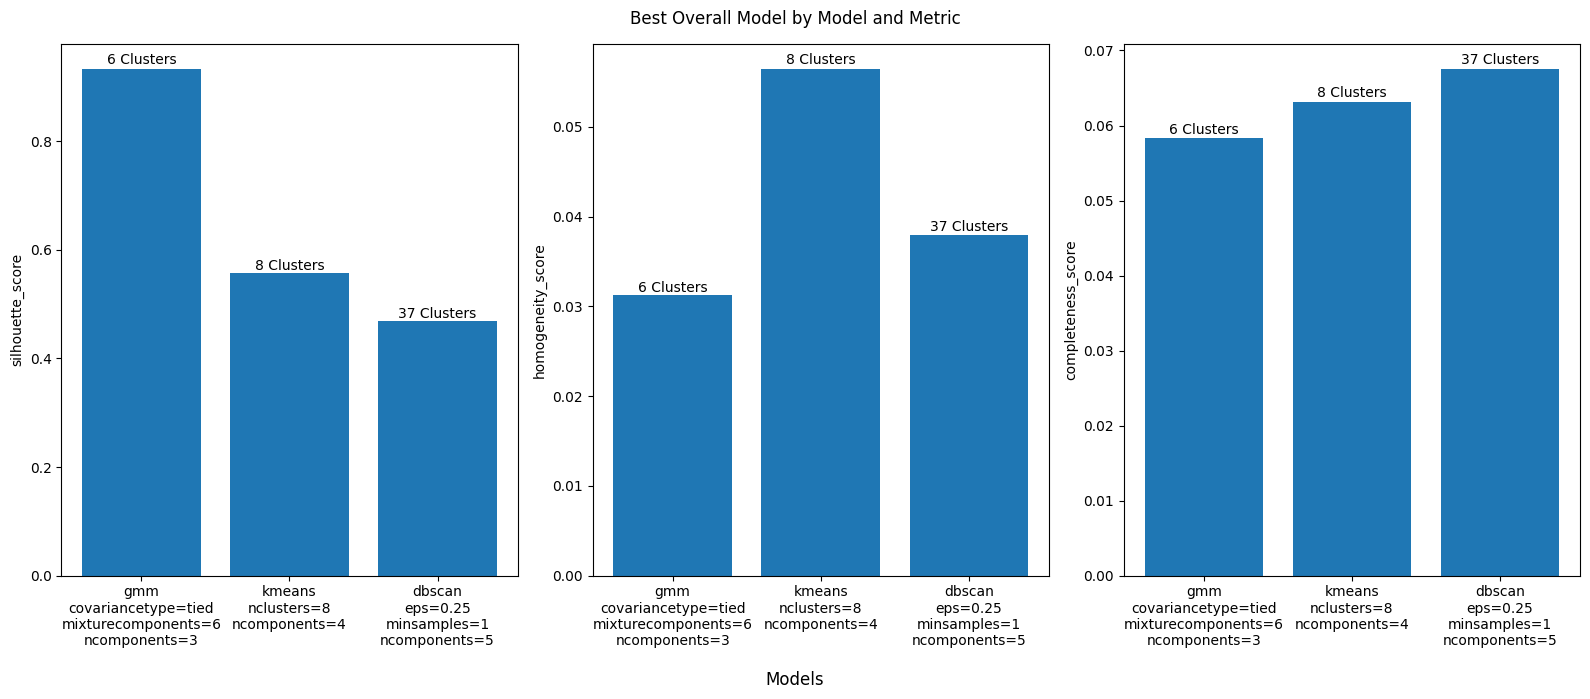

In [103]:
# Because the concatenation is occuring in the same order that the models were generated, we don't need to worry about special mapping methods
model_evaluation_norm_df.index = n_clusters_per_model.iloc[2:].index # ignoring the song_id and genre_id columns

best_norm_models = model_evaluation_norm_df.sort_values(by=['model', 'avg_composition'], ascending=[True, False]).drop_duplicates(subset='model').index.tolist()
best_norm_models = model_evaluation_df.loc[best_norm_models].reset_index(names='model_id')
best_norm_models.sort_values(by=METRICS[0], ascending=False, inplace=True) # Sort the first chart, and retain the model order for the last two

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,7))

for i in range(3):
    
    bar = ax[i].bar(
        best_norm_models.loc[:, 'model_id'].str.replace('_', '\n'),
        best_norm_models.loc[:, METRICS[i]],
        label=best_norm_models.loc[:, 'model_id'].tolist()
    )
    
    bar_labels = [f"{n_clusters} Clusters" for n_clusters in best_norm_models.loc[:, 'n_clusters']]
    
    rects = ax[i].patches
    
    for rect, label in zip(rects, bar_labels):
        ax[i].text(
            rect.get_x() + rect.get_width() / 2,
            1.01 * rect.get_height(),
            label,
            ha='center'
            )
    
    ax[i].set_ylabel(METRICS[i])

fig.supxlabel("Models")
fig.suptitle("Best Overall Model by Model and Metric")
fig.tight_layout();

Based on the best overall models' performance across these metrics, the `GaussianMixture` and the `KMeans` models are the two best models. On the one hand, the `GaussianMixture` model has a significantly `silhouette` score than the two other model classes, the `KMeans` model performs best or second best across all of them. However, it's still concerning that these models perform so poorly against the validation label set. With that in mind it is worth looking at the distribution the genres in the dataset they're based on:

<h4>Genre balance</h4>

Checking the balance of the genre classes

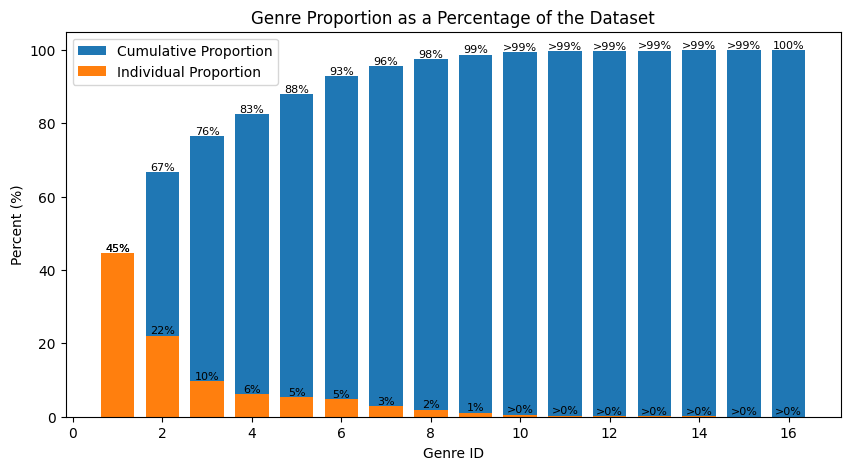

In [105]:
genre_balance = validation_df.loc[:, ['song_id', 'genre_id']].drop_duplicates().copy()
genre_balance = genre_balance.loc[:, ['genre_id']].value_counts()
genre_balance = 100 * genre_balance / NUM_SONGS
n_genres = len(genre_balance)
cum_genre_distribution = np.tri(n_genres) @ genre_balance

genre_dists = [
    cum_genre_distribution,
    genre_balance.values
]

labels = [
    "Cumulative Proportion",
    "Individual Proportion"
]

plt.figure(figsize=(10, 5))

x = range(1,17)

for j, genre_dist in enumerate(genre_dists):
    plt.bar(
        x,
        genre_dist,
        width=.75,
        label=labels[j]
    )
    
    plt.ylabel("Percent (%)")
    plt.xlabel("Genre ID")
    
    for i in range(n_genres):
        proportion = genre_dist[i]
        
        if proportion > 99 and proportion < 100:
            data_label = f">{np.floor(proportion):.0f}%"
        elif proportion > 0 and proportion < 1:
            data_label = f">{np.floor(proportion):.0f}%"
        else:
            data_label = f"{np.round(proportion):.0f}%"
        
        plt.text(
            i+1,
            genre_dist[i] + .5,
            data_label,
            fontsize=8,
            ha='center'
        )
    
plt.title("Genre Proportion as a Percentage of the Dataset")
plt.legend();

This distribution can provide some insight into why the best models for the `silhouette` score alone gravitated towards 8-10 clusters, when 10 genres comprise almost all of the data. This extreme skew also sheds light on why every model had difficulty achieving high `homogeneity` and `completeness` scores. Although this skew could suggest that the `DBSCAN` model would be preferrable due to its high `silhouette` score in conjunction with the fact that it does not need to have a predefined number of clusters, its main weakness is that is it not well suited to the task of predicting new genres. The `GaussianMixture` model, on the other hand, can predict cluster labels with new data and performs similarly on the `silhouette` score as `DBSCAN`. Therefore the 5 cluster `GaussianMixture` model seems to be the best choice, because it has the best combination of features between the `KMeans` and `DBSCAN` models - which can be applied in the future when more training data is available. Due to the discrepancy between the generated clusters and the actual number of clusters, we can consider the clusters as super-genres instead of specific genres/sub-genres.

Let's take a look at the composition of each of its clusters:

In [106]:
# Genre distributions will be more meaningful with actual labels
from tab_hero.dataio.tab_format import GENRE_MAP

GENRE_ID_MAP = {v: k for k, v in GENRE_MAP.items()}

In [107]:
# The best model had the following characteristics:
# model = 'gmm'
# covariance_type = 'full'
# mixture components = 5
# principal components = 3
best_model = 'gmm_covariancetype=full_mixturecomponents=5_ncomponents=3'

# Get the number of occurrences for each genre and cluster pair
best_model_genre_breakdown = song_genre.loc[:, ['genre_id', best_model]].groupby([best_model, 'genre_id']).agg('size').reset_index()

# Rename after aggregationg and restting of index
best_model_genre_breakdown.columns = ['cluster', 'genre_id', 'counts']

# Acquire genre labels
best_model_genre_breakdown.loc[:, 'genre'] = best_model_genre_breakdown.loc[:, 'genre_id'].apply(lambda x: GENRE_ID_MAP[x])

# Don't need genre_id anymore
best_model_genre_breakdown.drop('genre_id', inplace=True, axis=1)

# Organize counts into separate columns
best_model_genre_breakdown = pd.pivot(
    best_model_genre_breakdown,
    index='cluster',
    columns='genre',
    values='counts'
    )

# Set NaN values to 0 to allow for visualization
best_model_genre_breakdown.fillna(0, inplace=True)

# Create row and column totals to allow for percentage based visualizations
best_model_genre_breakdown.loc['row_total'] = best_model_genre_breakdown.sum(axis=0)
best_model_genre_breakdown.loc[:, 'col_total'] = best_model_genre_breakdown.sum(axis=1)

# Show result
best_model_genre_breakdown

genre,alternative,blues,classical,country,electronic,folk,hiphop,indie,jazz,metal,other,pop,punk,reggae,rock,unknown,col_total
cluster,,,,,,,,,,,,,,,,,
0,79.0,2.0,0.0,53.0,1.0,0.0,34.0,33.0,3.0,223.0,28.0,68.0,36.0,17.0,502.0,0.0,1079.0
1,488.0,28.0,0.0,68.0,3.0,1.0,31.0,294.0,3.0,957.0,193.0,80.0,320.0,1.0,2124.0,2.0,4593.0
2,14.0,0.0,7.0,1.0,4.0,0.0,7.0,4.0,0.0,158.0,45.0,15.0,16.0,0.0,115.0,0.0,386.0
3,36.0,8.0,0.0,2.0,0.0,0.0,2.0,7.0,0.0,82.0,33.0,19.0,24.0,0.0,127.0,0.0,340.0
4,3.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,2.0,14.0,3.0,2.0,0.0,9.0,0.0,37.0
row_total,620.0,39.0,7.0,124.0,8.0,1.0,74.0,341.0,6.0,1422.0,313.0,185.0,398.0,18.0,2877.0,2.0,6435.0


Let's visualize the cluster size distribution

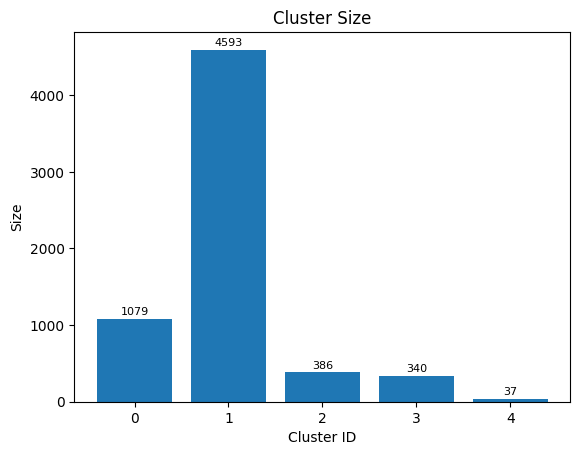

In [108]:
plt.bar(
    best_model_genre_breakdown.index[:-1],
    best_model_genre_breakdown.col_total[:-1]
)

for i in best_model_genre_breakdown.index[:-1]:
                
    plt.text(
        i,
        best_model_genre_breakdown.col_total[i] + 50,
        int(best_model_genre_breakdown.col_total[i]),
        fontsize=8,
        ha='center'
    )
        
plt.xlabel('Cluster ID')
plt.ylabel('Size')
plt.title("Cluster Size");

In [109]:
# Distribution of genres across clusters
genre_cluster_distribution = 100 * best_model_genre_breakdown.iloc[:5, :16] /  best_model_genre_breakdown.iloc[5, :16]
genre_cluster_distribution

genre,alternative,blues,classical,country,electronic,folk,hiphop,indie,jazz,metal,other,pop,punk,reggae,rock,unknown
cluster,,,,,,,,,,,,,,,,
0,12.741935,5.128205,0.0,42.741935,12.5,0.0,45.945946,9.677419,50.0,15.682138,8.945687,36.756757,9.045226,94.444444,17.448731,0.0
1,78.709677,71.794872,0.0,54.838710,37.5,100.0,41.891892,86.217009,50.0,67.299578,61.661342,43.243243,80.402010,5.555556,73.826903,100.0
2,2.258065,0.000000,100.0,0.806452,50.0,0.0,9.459459,1.173021,0.0,11.111111,14.376997,8.108108,4.020101,0.000000,3.997219,0.0
3,5.806452,20.512821,0.0,1.612903,0.0,0.0,2.702703,2.052786,0.0,5.766526,10.543131,10.270270,6.030151,0.000000,4.414320,0.0
4,0.483871,2.564103,0.0,0.000000,0.0,0.0,0.000000,0.879765,0.0,0.140647,4.472843,1.621622,0.502513,0.000000,0.312826,0.0


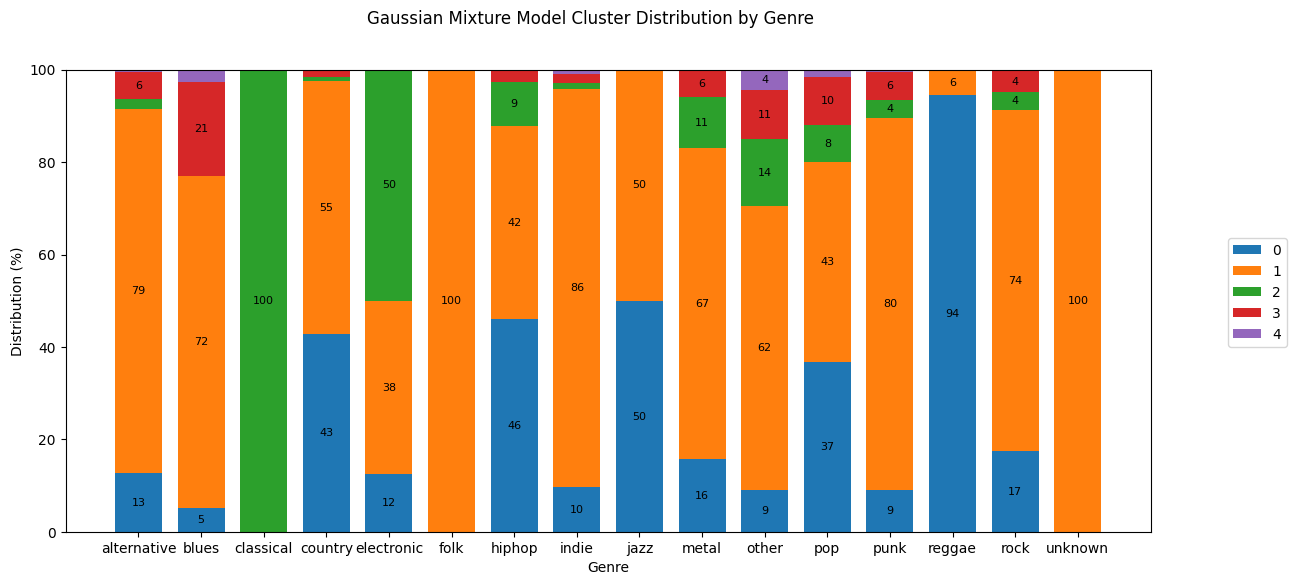

In [110]:
fig, ax = plt.subplots(figsize=(14,6))

# Initialize a bottom value
bottom_vals = np.zeros(16)
for cluster in genre_cluster_distribution.index:
    
    # Row sum everything up to the last row
    if cluster > 0:
        bottom_vals = genre_cluster_distribution.loc[:cluster-1].sum(axis=0)
    
    # Save in a variable to reuse contents
    genre_dist = genre_cluster_distribution.loc[cluster]
    
    ax.bar(
        genre_cluster_distribution.columns,
        genre_dist,
        bottom = bottom_vals,
        label=cluster,
        width=.75
    )
    
    # Require top and bottom val to plot in middle of a stacked bar
    top_vals = genre_cluster_distribution.loc[:cluster].sum(axis=0)
        
    for genre, (bottom, top) in enumerate(zip(bottom_vals, top_vals)):
        
        data_label = genre_dist.values[genre]
        
        # When the bars are too small, don't clutter chart with label
        if data_label < 3:
            continue
        
        data_label = round(data_label)
        
        plt.text(
            genre,
            (bottom + top) / 2,
            data_label,
            fontsize=8,
            ha='center',
            va='center'
        )
        
ax.set_ylabel("Distribution (%)")
ax.set_xlabel("Genre")

fig.suptitle("Gaussian Mixture Model Cluster Distribution by Genre")
fig.legend(loc='outside center right');

We can also investigate the proportion of genres within clusters.

In [111]:
# Distribution of genres across clusters
cluster_genre_distribution = 100 * best_model_genre_breakdown.iloc[:5, :16].div(best_model_genre_breakdown.iloc[:5, 16], axis=0)
cluster_genre_distribution = cluster_genre_distribution.T
cluster_genre_distribution

cluster,0,1,2,3,4
genre,,,,,
alternative,7.321594,10.624864,3.626943,10.588235,8.108108
blues,0.185357,0.609623,0.000000,2.352941,2.702703
classical,0.000000,0.000000,1.813472,0.000000,0.000000
country,4.911956,1.480514,0.259067,0.588235,0.000000
electronic,0.092678,0.065317,1.036269,0.000000,0.000000
folk,0.000000,0.021772,0.000000,0.000000,0.000000
hiphop,3.151066,0.674940,1.813472,0.588235,0.000000
indie,3.058387,6.401045,1.036269,2.058824,8.108108
jazz,0.278035,0.065317,0.000000,0.000000,0.000000


In [112]:
cluster_genre_cum_distribution = cluster_genre_distribution.cumsum(axis=0)
cluster_genre_cum_distribution

cluster,0,1,2,3,4
genre,,,,,
alternative,7.321594,10.624864,3.626943,10.588235,8.108108
blues,7.506951,11.234487,3.626943,12.941176,10.810811
classical,7.506951,11.234487,5.440415,12.941176,10.810811
country,12.418906,12.715001,5.699482,13.529412,10.810811
electronic,12.511585,12.780318,6.735751,13.529412,10.810811
folk,12.511585,12.802090,6.735751,13.529412,10.810811
hiphop,15.662651,13.477030,8.549223,14.117647,10.810811
indie,18.721038,19.878075,9.585492,16.176471,18.918919
jazz,18.999073,19.943392,9.585492,16.176471,18.918919


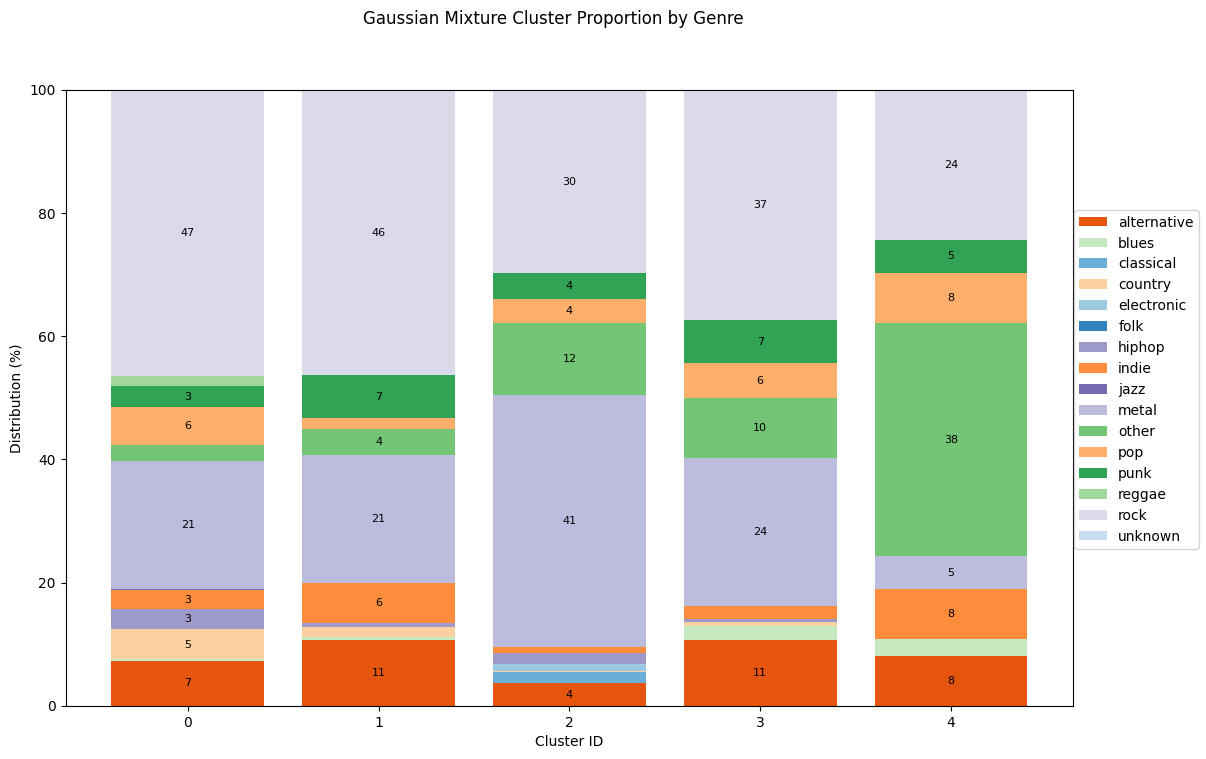

In [113]:
fig, ax = plt.subplots(figsize=(13,8))

x = cluster_genre_distribution.columns
prev_genre = ''

genres = cluster_genre_distribution.index

cmap = colormaps['tab20c']

# Shuffle so colors are easier to distinguish
colors = cmap(range(0, len(genres)))
np.random.shuffle(colors)

bottom_vals = np.zeros(5)

for genre, color in zip(genres, colors):
    
    if prev_genre != '':
        bottom_vals = cluster_genre_cum_distribution.loc[prev_genre]
    
    cluster_prop = cluster_genre_distribution.loc[genre]
    
    ax.bar(
        x,
        cluster_prop,
        label=genre,
        color=color,
        bottom=bottom_vals
    )
    
    prev_genre = genre
    
    top_vals = cluster_genre_cum_distribution.loc[genre]
        
    for i, (bottom, top) in enumerate(zip(bottom_vals, top_vals)):
        
        data_label = cluster_prop.values[i]
        
        # When the bars are too small, don't clutter chart with label
        if data_label < 3:
            continue
        
        data_label = round(data_label)
        
        ax.text(
            i,
            (bottom + top) / 2,
            data_label,
            fontsize=8,
            ha='center',
            va='center'
        )
        
ax.set_ylabel("Distribution (%)")
ax.set_xlabel("Cluster ID")

fig.suptitle("Gaussian Mixture Cluster Proportion by Genre")
fig.legend(loc='outside center right');

Given the overall low `homogeneity` and `completeness` scores, it's not too surprising that these genre and cluster distribution viusalizations depict clusters with a broad array of genres. As far as clustering is concerned, it seems that our dataset did not contain enough discriminative features to distinguish between the array of imbalanced classes.

# Deprecate?

##### Functions

In [ ]:
def plot_subplots(grouped_df, metrics, title, xlabel, ylim_bounds=(0,1), ncols=3, figsize=(10,5), sharex=True, sharey=True, bar=False):
    fig, axs = plt.subplots(nrows=1, ncols=ncols, figsize=figsize,
                            sharex=sharex, sharey=sharey)
    
    x_data = grouped_df.index
    
    for i in range(ncols):
        # Access current axis
        ax = axs[i]
        
        # Assign current metric
        metric = metrics[i]
        
        # Plot data inside each chart        
        y_data = grouped_df.loc[:, metric]
        if bar:
            ax.bar(x_data, y_data)
        else:
            ax.plot(x_data, y_data)
        
        # Update figure axes and labels       
        ax.set_ylim(ylim_bounds)
        ax.set_ylabel(metric)
        ax.set_xlabel(xlabel)

    fig.suptitle(title)

In [ ]:
def plot_subplots_2hparams(grouped_df, hparam1, hparam2, metrics, title,
                           xlabel, ylim_bounds=(0,1), ncols=3, figsize=(10,5),
                           sharex=True, sharey=True, bar=False):
    
    fig, axs = plt.subplots(nrows=1, ncols=ncols, figsize=figsize,
                            sharex=sharex, sharey=sharey)
    
    x_data = grouped_df.loc[:, hparam1].unique()
    
    
    for i in range(ncols):
        # Access current axis
        ax = axs[i]
        
        # Assign current metric
        metric = metrics[i]
                
        # Plot data inside each chart        
        y_data = grouped_df.loc[:, metric]
        # Plot data inside each chart
        for j, hparam2_val in enumerate(grouped_df.loc[:, hparam2].unique()):
            agg = grouped_df.loc[grouped_df.loc[:, hparam2] == hparam2_val, [hparam1, metric]].groupby(hparam1).mean()
            y_data = agg.loc[:, metric]
            
            if bar:
                pass
            else:
                ax.plot(x_data, y_data, label=f"{hparam2_val} {hparam2}" if i == 2 else "")
        
        # Update figure axes and labels       
        ax.set_ylim(ylim_bounds)
        ax.set_ylabel(metric)
        ax.set_xlabel(xlabel)

    fig.suptitle(title)
    fig.legend()

### Incosistent song lengths

There are several songs who have inconsistent `duration_sec` values across each record they appear in.

In [114]:
# Find these songs
inconsistent_dur = song_and_instrument_df.loc[:, ['song_id', 'duration_sec']].drop_duplicates().groupby('song_id').agg(list)
inconsistent_dur.loc[:, '_len'] = inconsistent_dur.loc[:, 'duration_sec'].apply(lambda x: len(x))
inconsistent_dur = inconsistent_dur.loc[inconsistent_dur._len > 1, :]

# Display the songs
relevant_columns = ['song_id', 'instrument_id', 'duration_sec']
inconsistent_dur = song_and_instrument_df.loc[song_and_instrument_df.song_id.isin(inconsistent_dur.index), relevant_columns].sort_values(by=relevant_columns)

# Save the indices
inconsistent_dur = inconsistent_dur.reset_index(names="record_index")

inconsistent_dur.head(10)

KeyError: "['duration_sec'] not in index"

Identify the "worst" duration for a song by the least popular option, or whichever is first if there are ties

In [ ]:
relevant_columns = ['song_id', 'duration_sec', 'record_index']
groupby_columns = ['song_id', 'duration_sec']

# Count occurences, and track the indices in each group
agg_mapper = {
    'duration_sec': 'size',
    'record_index': list
}
duration_counts = inconsistent_dur.loc[:, relevant_columns].groupby(groupby_columns).agg(agg_mapper)
duration_counts.columns = ['counts', 'indices']
duration_counts.reset_index(inplace=True)


worst_durations = duration_counts.sort_values(by=['song_id', 'counts']).explode('indices')#.drop_duplicates(subset=['song_id'])
# Gather all but last indices within each song
all_but_last_song_index = worst_durations.duplicated(subset='song_id', keep='last')
worst_indices = worst_durations.loc[all_but_last_song_index].loc[:, 'indices']
worst_indices

0      2281
1      2279
3      3929
2      3928
4      6132
      ...  
60    12788
62    12863
63    12861
65    12933
64    12931
Name: indices, Length: 68, dtype: object

In [ ]:
prev_len = len(song_and_instrument_df)
song_and_instrument_df = song_and_instrument_df.loc[~song_and_instrument_df.index.isin(worst_indices)]
curr_len = len(song_and_instrument_df)

print(f"We have removed {prev_len-curr_len} records")

We have removed 68 records


Confirm that there are now no duplicate records

In [ ]:
song_and_instrument_counts = song_and_instrument_df.loc[:, ['song_id', 'instrument_id']].drop_duplicates().groupby(['song_id', 'instrument_id']).agg('size')
assert np.array([1]) == song_and_instrument_counts.reset_index(name='counts').counts.unique()